In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
import ray
import gmpy2
import statistics as st
import pickle
from src.PDE_Solver import PDESolver_nd
from src.solver_2d import false_transient_one_iteration_cpp,false_transient_one_iteration_python
from src.derivative import derivatives_2d, derivative_1d
from joblib import Parallel, delayed
from src.supportfunctions import finiteDiff, PDESolver_2d
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300



ray.init(num_cpus=5, num_gpus=1) # Only call this once.

2021-08-10 08:23:31,744	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.1.4',
 'raylet_ip_address': '192.168.1.4',
 'redis_address': '192.168.1.4:45717',
 'object_store_address': '/tmp/ray/session_2021-08-10_08-23-28_931417_17190/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-10_08-23-28_931417_17190/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-08-10_08-23-28_931417_17190',
 'metrics_export_port': 53327,
 'node_id': 'c07c268ddb6404d373dcdfbbb64b8493a56e33931243f8ee552e4032'}

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [18]:
@ray.remote
def solve_prep(y1_mat, y2_mat, γ3, λ, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:

        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])    
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start)
        print(lhs_error)
    print_results="Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1])
    print(print_results)
    result = dict( λ= λ,v0=v0, ems=ems, πa=πa, episode = episode, rhs_error = rhs_error, lhs_error= lhs_error )
    return (result)

In [19]:
tol      = 1e-6
ϵ        = 0.1
max_iter = 10000
fraction = .2
γ3_list  = np.linspace(0, 10,2)
λ_list   =  np.linspace(4.8, 4.8, 1)
testing_name = 4.8

In [ ]:
ray.shutdown()

In [ ]:
safe = [solve_prep.remote(y1_mat, y2_mat, γ3, λ, tol, ϵ, max_iter, fraction) for λ in λ_list for γ3 in γ3_list]
safe = ray.get(safe)

(pid=17216) 0.09509725579573096
(pid=17216) 0.11018632344703752
(pid=17216) 0.11749295343459673
(pid=17216) 0.12180025450378235
(pid=17217) 66.48214388000567
(pid=17216) 0.1241524967424721
(pid=17216) 0.1250141218804846
(pid=17217) 48.74810700958927
(pid=17217) 34.95358053971516
(pid=17217) 25.05312589708902
(pid=17216) 0.12495003137516697
(pid=17217) 17.98074821681336
(pid=17216) 0.12398510221336839
(pid=17217) 12.939731606393003
(pid=17217) 9.34766723294306
(pid=17216) 0.1218203031283227
(pid=17217) 6.784946188417571
(pid=17216) 0.12020353751719726
(pid=17217) 4.95214023578697
(pid=17217) 3.6368943822825983
(pid=17216) 0.11881874774230375
(pid=17217) 2.689155381520756
(pid=17216) 0.1168170361506439
(pid=17217) 2.003075426446692
(pid=17217) 1.5039990757157895
(pid=17216) 0.11606956554165021
(pid=17217) 1.1392098495856118
(pid=17216) 0.11688567225211749
(pid=17217) 0.8713989774339481
(pid=17217) 0.6740680797647514
(pid=17216) 0.1173490538637409
(pid=17217) 0.5282946445391801
(pid=17216

(pid=17216) 0.08502792401004933
(pid=17217) 0.5807354519280183
(pid=17217) 0.5871656231931599
(pid=17217) 0.5935592600066153
(pid=17216) 0.08473158950879744
(pid=17217) 0.5999092101447623
(pid=17217) 0.6062067809344152
(pid=17217) 0.6124413484234958
(pid=17217) 0.6186001249575535
(pid=17216) 0.08443907068924061
(pid=17217) 0.6246677230239195
(pid=17217) 0.6306259999277097
(pid=17217) 0.6364536215238559
(pid=17217) 0.6421260674949814
(pid=17216) 0.08415017566698046
(pid=17217) 0.6476156470248773
(pid=17217) 0.6528917670333678
(pid=17217) 0.6579217661872905
(pid=17217) 0.662671947033151
(pid=17216) 0.08386476692887501
(pid=17217) 0.6671091856543487
(pid=17217) 0.6712029670980302
(pid=17217) 0.6749275157336321
(pid=17217) 0.6782638504425531
(pid=17216) 0.08358276153589972
(pid=17217) 0.6812016477551319
(pid=17217) 0.6837400650612446
(pid=17217) 0.6858880175509752
(pid=17217) 0.6876632396100968
(pid=17216) 0.08330412641909812
(pid=17217) 0.6890907211555097
(pid=17217) 0.6902007544703892
(p

(pid=17217) 0.6104735503441461
(pid=17217) 0.60986368748015
(pid=17216) 0.07785468720060362
(pid=17217) 0.6092544351517937
(pid=17217) 0.6086457911418641
(pid=17217) 0.608037728487254
(pid=17217) 0.6074302946241694
(pid=17217) 0.6068234685617568
(pid=17217) 0.6062172492096352
(pid=17216) 0.07763222284771332
(pid=17217) 0.6056116359496322
(pid=17217) 0.6050066292267431
(pid=17217) 0.6044022281306383
(pid=17217) 0.6037984290063392
(pid=17217) 0.6031952320387646
(pid=17217) 0.6025926395243353
(pid=17216) 0.07741156253615156
(pid=17217) 0.601990650396349
(pid=17217) 0.6013892632619466
(pid=17217) 0.6007884773372574
(pid=17217) 0.6001882918054413
(pid=17217) 0.5995886788440963
(pid=17217) 0.5989896856902632
(pid=17216) 0.0771926620828911
(pid=17217) 0.5983912925401924
(pid=17217) 0.5977934981870092
(pid=17217) 0.5971963016539128
(pid=17217) 0.5965997245407806
(pid=17217) 0.596003724776093
(pid=17217) 0.59540829235047
(pid=17217) 0.5948134764640045
(pid=17216) 0.07697550777675755
(pid=17217)

(pid=17217) 0.5223369810928347
(pid=17217) 0.5218151622572265
(pid=17217) 0.5212938686034008
(pid=17216) 0.07185962611043761
(pid=17217) 0.5207730971156366
(pid=17217) 0.5202528468107914
(pid=17217) 0.5197331144727357
(pid=17217) 0.5192138973153604
(pid=17216) 0.07168042320229828
(pid=17217) 0.5186951984613231
(pid=17217) 0.5181770170278099
(pid=17217) 0.5176593530144302
(pid=17217) 0.5171422064808695
(pid=17216) 0.07150234400132627
(pid=17217) 0.5166255780422446
(pid=17217) 0.5161094676674338
(pid=17217) 0.5155938742170818
(pid=17217) 0.5150787961642322
(pid=17217) 0.51456423268192
(pid=17216) 0.07132537515454951
(pid=17217) 0.5140501835111166
(pid=17217) 0.5135366484189063
(pid=17217) 0.5130236270336397
(pid=17216) 0.07114949956593675
(pid=17217) 0.5125111185219922
(pid=17217) 0.5119991213591746
(pid=17217) 0.5114876343380459
(pid=17217) 0.5109766570461716
(pid=17217) 0.5104661897130569
(pid=17216) 0.07097470241592241
(pid=17217) 0.5099562392834756
(pid=17217) 0.5094467918643986
(pid

(pid=17217) 0.4532228261236071
(pid=17217) 0.45277005409293025
(pid=17216) 0.06486732484784374
(pid=17217) 0.45231773465790326
(pid=17217) 0.4518658672819953
(pid=17216) 0.06472615985746888
(pid=17217) 0.45141445147333314
(pid=17217) 0.45096348670067954
(pid=17217) 0.45051297235616516
(pid=17216) 0.06458565408740347
(pid=17217) 0.45006290797189763
(pid=17217) 0.44961328302960624
(pid=17216) 0.06444580074739026
(pid=17217) 0.44916412258814375
(pid=17217) 0.44871541186974895
(pid=17217) 0.4482671503367186
(pid=17216) 0.06430659297432584
(pid=17217) 0.447819337198041
(pid=17217) 0.4473719715581126
(pid=17216) 0.06416802341010275
(pid=17217) 0.44692505209308564
(pid=17217) 0.4464785774860758
(pid=17216) 0.06403008512730235
(pid=17217) 0.4460325467651316
(pid=17217) 0.4455869593725126
(pid=17217) 0.44514181545711295
(pid=17216) 0.06389277176455321
(pid=17217) 0.44469711527611366
(pid=17217) 0.4442528589016348
(pid=17216) 0.06375607732562738
(pid=17217) 0.44380904619060857
(pid=17217) 0.4433

(pid=17217) 0.4023986585053052
(pid=17216) 0.056717406759185796
(pid=17217) 0.40199666068424733
(pid=17216) 0.05660901151883113
(pid=17217) 0.4015950646692801
(pid=17216) 0.056500989704246773
(pid=17217) 0.4011938701187745
(pid=17217) 0.4007930768462842
(pid=17216) 0.05639333999958085
(pid=17217) 0.4003926846517203
(pid=17216) 0.05628606044146167
(pid=17217) 0.39999269223379486
(pid=17216) 0.056179148649821986
(pid=17217) 0.3995930999811037
(pid=17216) 0.0560726021977076
(pid=17217) 0.39919390737196636
(pid=17217) 0.3987951135572132
(pid=17216) 0.05596641844650252
(pid=17217) 0.3983967183539505
(pid=17216) 0.05586059415841227
(pid=17217) 0.3979987217747549
(pid=17216) 0.05575512609125477
(pid=17217) 0.3976011226332332
(pid=17216) 0.05565001116497825
(pid=17217) 0.3972039204317923
(pid=17217) 0.3968071148568697
(pid=17216) 0.05554524618832435
(pid=17217) 0.3964107057990418
(pid=17216) 0.055440828520427754
(pid=17217) 0.3960146927674657
(pid=17216) 0.05533675573614838
(pid=17217) 0.39561

(pid=17216) 0.048461191472077836
(pid=17217) 0.36521701523270167
(pid=17216) 0.0483779285818553
(pid=17217) 0.3648521632064927
(pid=17216) 0.048294890117754896
(pid=17217) 0.3644876755451065
(pid=17216) 0.04821207461368271
(pid=17217) 0.364123551868758
(pid=17216) 0.04812948084707891
(pid=17217) 0.3637597918622504
(pid=17217) 0.36339639520427625
(pid=17216) 0.04804710803963275
(pid=17216) 0.04796495505952958
(pid=17217) 0.3630333615794257
(pid=17217) 0.36267069067960733
(pid=17216) 0.04788302089785201
(pid=17216) 0.047801304441099646
(pid=17217) 0.36230838611793104
(pid=17216) 0.04771980460204883
(pid=17217) 0.3619464392610894
(pid=17216) 0.04763852034830318
(pid=17217) 0.36158485401713847
(pid=17217) 0.3612236300106275
(pid=17216) 0.04755745048243387
(pid=17217) 0.36086276694739183
(pid=17216) 0.04747659417509542
(pid=17217) 0.3605022644024558
(pid=17216) 0.04739595059072066
(pid=17217) 0.36014212202879037
(pid=17216) 0.0473155185535612
(pid=17217) 0.3597823394694899
(pid=17216) 0.047

(pid=17216) 0.041755582585087936
(pid=17217) 0.33279883104725627
(pid=17216) 0.04168894151499014
(pid=17217) 0.33246636503655225
(pid=17216) 0.04162245258899411
(pid=17217) 0.33213423112194107
(pid=17216) 0.041556115062535426
(pid=17217) 0.3318024289788468
(pid=17216) 0.041489928303724
(pid=17217) 0.33147095827544604
(pid=17216) 0.04142389151050363
(pid=17217) 0.3311398186748704
(pid=17216) 0.0413580045867068
(pid=17217) 0.330809009843378
(pid=17216) 0.04129226676162112
(pid=17217) 0.330478531447298
(pid=17217) 0.330148383099953
(pid=17216) 0.041226677456376315
(pid=17216) 0.041161235986568734
(pid=17217) 0.3298185644998597
(pid=17216) 0.04109594199214861
(pid=17217) 0.32948907532002636
(pid=17216) 0.0410307949409372
(pid=17217) 0.329159915233177
(pid=17216) 0.04096579417239621
(pid=17217) 0.3288310839077013
(pid=17216) 0.04090093912519688
(pid=17217) 0.32850258101134955
(pid=17216) 0.040836229069403096
(pid=17217) 0.32817440621982996
(pid=17216) 0.04077166382799202
(pid=17217) 0.32784

(pid=17217) 0.303561516460249
(pid=17216) 0.03619651635585974
(pid=17217) 0.30325825836214904
(pid=17216) 0.036141804562426216
(pid=17217) 0.30295530320337605
(pid=17216) 0.03608720315849023
(pid=17217) 0.3026526506856442
(pid=17216) 0.03603271186764623
(pid=17217) 0.30235030051130707
(pid=17216) 0.03597833050167143
(pid=17217) 0.3020482523834289
(pid=17216) 0.03592405860362469
(pid=17217) 0.30174650600251596
(pid=17216) 0.035869895847824296
(pid=17217) 0.3014450610682218
(pid=17216) 0.03581584184158437
(pid=17217) 0.30114391727927625
(pid=17216) 0.03576189620635439
(pid=17217) 0.3008430743385304
(pid=17216) 0.03570805888315487
(pid=17217) 0.30054253194037983
(pid=17216) 0.03565432938104074
(pid=17217) 0.3002422897768042
(pid=17216) 0.03560070735909804
(pid=17217) 0.2999423475453966
(pid=17216) 0.03554719245702387
(pid=17217) 0.2996427049431105
(pid=17216) 0.0354937843076808
(pid=17217) 0.2993433616559571
(pid=17216) 0.035440482556672315
(pid=17217) 0.29904432402076964
(pid=17216) 0.03

(pid=17217) 0.2771696384328237
(pid=17216) 0.03158647069258613
(pid=17217) 0.27689274579472567
(pid=17216) 0.03154066545338896
(pid=17217) 0.2766161297584091
(pid=17216) 0.031494944885968046
(pid=17217) 0.27633979004967557
(pid=17216) 0.03144930873718366
(pid=17217) 0.27606372639368715
(pid=17216) 0.03140375675683593
(pid=17217) 0.2757879385153217
(pid=17216) 0.03135828870617363
(pid=17217) 0.275512426132849
(pid=17216) 0.03131290419241317
(pid=17217) 0.27523718896425464
(pid=17216) 0.031267603221989404
(pid=17217) 0.27496222674940896
(pid=17216) 0.03122238564456481
(pid=17217) 0.2746875392178083
(pid=17216) 0.03117725113179759
(pid=17217) 0.2744131260951832
(pid=17216) 0.031132199490184753
(pid=17217) 0.2741389871167854
(pid=17216) 0.03108723050646578
(pid=17217) 0.2738651220009558
(pid=17216) 0.031042343960132612
(pid=17217) 0.2735915304786829
(pid=17216) 0.03099753962915841
(pid=17217) 0.27331821227470243
(pid=17216) 0.030952817295100132
(pid=17217) 0.2730451671202161
(pid=17216) 0.

(pid=17216) 0.027700599230877643
(pid=17217) 0.25307229718144697
(pid=17216) 0.027661735949560118
(pid=17217) 0.2528194772865078
(pid=17216) 0.027622939781934974
(pid=17217) 0.2525669099497918
(pid=17216) 0.02758421055899518
(pid=17217) 0.25231459492054853
(pid=17216) 0.027545548112652973
(pid=17217) 0.2520625319480274
(pid=17216) 0.027506952277827068
(pid=17217) 0.25181072077494093
(pid=17216) 0.027468422894174616
(pid=17216) 0.027429959806513082
(pid=17217) 0.25155916114933063
(pid=17216) 0.02739156286352351
(pid=17217) 0.2513078528263435
(pid=17216) 0.027353231916742438
(pid=17217) 0.2510567955551579
(pid=17216) 0.02731496681790624
(pid=17217) 0.25080598908836294
(pid=17216) 0.02727676741923979
(pid=17217) 0.25055543317499485
(pid=17216) 0.027238633571333715
(pid=17217) 0.25030512756735845
(pid=17216) 0.027200565124303466
(pid=17217) 0.2500550720166217
(pid=17216) 0.027162561927256412
(pid=17217) 0.24980526627494726
(pid=17216) 0.027124623828633787
(pid=17217) 0.24955571009428468
(p

(pid=17217) 0.23130104374359917
(pid=17216) 0.024354225864633428
(pid=17217) 0.23106997393981032
(pid=17216) 0.024320987397348226
(pid=17217) 0.23083913499057473
(pid=17216) 0.024287803352507353
(pid=17217) 0.23060852666333176
(pid=17216) 0.024254673594996667
(pid=17216) 0.02422159798060708
(pid=17217) 0.23037814872658657
(pid=17216) 0.024188576376462656
(pid=17217) 0.23014800094962595
(pid=17217) 0.22991808310116824
(pid=17216) 0.02415560866384059
(pid=17216) 0.024122694732580108
(pid=17217) 0.22968839495071336
(pid=17216) 0.024089834475513605
(pid=17217) 0.22945893626797442
(pid=17216) 0.024057027784887275
(pid=17217) 0.22922970682280663
(pid=17216) 0.024024274550185076
(pid=17217) 0.22900070638613101
(pid=17216) 0.023991574658439596
(pid=17217) 0.22877193472794488
(pid=17216) 0.0239589279940855
(pid=17217) 0.22854339161888504
(pid=17216) 0.023926334440327324
(pid=17217) 0.22831507683029884
(pid=17216) 0.023893793879010694
(pid=17217) 0.2280869901333915
(pid=17216) 0.0238613061918924

(pid=17216) 0.0215101259473105
(pid=17217) 0.2114027554682707
(pid=17216) 0.021481440818007513
(pid=17217) 0.21119156417455542
(pid=17216) 0.02145280060974919
(pid=17217) 0.2109805838544787
(pid=17216) 0.021424205243771866
(pid=17217) 0.21076981429672514
(pid=17216) 0.02139565463918025
(pid=17217) 0.21055925529040564
(pid=17216) 0.02136714871216583
(pid=17217) 0.21034890662384953
(pid=17216) 0.02133868737600686
(pid=17217) 0.2101387680874467
(pid=17216) 0.021310270542374
(pid=17217) 0.20992883947094754
(pid=17216) 0.021281898121463527
(pid=17217) 0.2097191205628235
(pid=17216) 0.021253570023223034
(pid=17216) 0.021225286157324774
(pid=17217) 0.20950961115545397
(pid=17216) 0.021197046434391353
(pid=17217) 0.20930031103752356
(pid=17216) 0.021168850764725633
(pid=17217) 0.20909122000283276
(pid=17216) 0.021140699059714052
(pid=17217) 0.2088823378406346
(pid=17216) 0.02111259123174669
(pid=17217) 0.20867366434330847
(pid=17216) 0.02108452719335574
(pid=17217) 0.20846519930223906
(pid=172

(pid=17216) 0.01902370165129952
(pid=17217) 0.1932162637873347
(pid=17216) 0.018998842138202576
(pid=17217) 0.19302324041106544
(pid=17216) 0.018974020154374216
(pid=17217) 0.19283040986259437
(pid=17216) 0.018949235602487846
(pid=17217) 0.19263777194787224
(pid=17216) 0.018924488402252138
(pid=17217) 0.19244532647469725
(pid=17216) 0.018899778484593455
(pid=17217) 0.1922530732515071
(pid=17216) 0.018875105786166912
(pid=17217) 0.19206101208716575
(pid=17216) 0.01885047024622999
(pid=17217) 0.19186914278797929
(pid=17216) 0.01882587180542572
(pid=17217) 0.19167746516409068
(pid=17216) 0.01880131040488564
(pid=17217) 0.19148597902386655
(pid=17216) 0.01877678598507515
(pid=17217) 0.19129468417609985
(pid=17216) 0.018752298485820162
(pid=17217) 0.19110358043064934
(pid=17216) 0.01872784784576531
(pid=17217) 0.1909126675948869
(pid=17216) 0.01870343417450293
(pid=17217) 0.1907219454806608
(pid=17216) 0.01867905721764984
(pid=17217) 0.19053141389655082
(pid=17216) 0.018654716707704466
(pid

(pid=17216) 0.016863771856572285
(pid=17217) 0.1767708928572631
(pid=17216) 0.016842125605975866
(pid=17217) 0.17659429835532592
(pid=17216) 0.01682051108877758
(pid=17217) 0.17641788026971028
(pid=17216) 0.01679892819744566
(pid=17217) 0.17624163842256735
(pid=17216) 0.016777376852319392
(pid=17217) 0.17606557263981415
(pid=17216) 0.016755856997416885
(pid=17217) 0.1758896827447387
(pid=17216) 0.01673436858749433
(pid=17217) 0.17571396856133958
(pid=17216) 0.01671291158094057
(pid=17217) 0.17553842991503643
(pid=17216) 0.016691485933000294
(pid=17217) 0.17536306664176493
(pid=17216) 0.016670091595392122
(pid=17217) 0.17518787855671292
(pid=17216) 0.01664872851671717
(pid=17217) 0.17501286548650796
(pid=17216) 0.01662739664342716
(pid=17217) 0.1748380272537986
(pid=17216) 0.016606095920366215
(pid=17217) 0.17466336368549662
(pid=17216) 0.01658482629281366
(pid=17217) 0.1744888746060269
(pid=17216) 0.01656358770564026
(pid=17217) 0.1743145598420881
(pid=17216) 0.01654238010355691
(pid=1

(pid=17216) 0.014979377530766058
(pid=17217) 0.16172525560456563
(pid=17216) 0.014960455503549852
(pid=17217) 0.16156369188664144
(pid=17216) 0.01494156045762196
(pid=17217) 0.16140228956928127
(pid=17216) 0.014922692344248034
(pid=17217) 0.1612410484924709
(pid=17216) 0.014903851116816469
(pid=17217) 0.1610799684944908
(pid=17216) 0.014885036731708823
(pid=17216) 0.014866249145146782
(pid=17217) 0.1609190494151136
(pid=17217) 0.16075829109304607
(pid=17216) 0.014847488315830049
(pid=17216) 0.014828754200912897
(pid=17217) 0.1605976933687714
(pid=17216) 0.014810046758588769
(pid=17217) 0.16043725608035686
(pid=17216) 0.014791365946109636
(pid=17217) 0.16027697906892513
(pid=17216) 0.014772711720825171
(pid=17217) 0.1601168621739646
(pid=17216) 0.014754084039418913
(pid=17217) 0.15995690523574524
(pid=17216) 0.014735482858547755
(pid=17217) 0.15979710809482128
(pid=17216) 0.014716908134531081
(pid=17217) 0.15963747059046796
(pid=17216) 0.014698360025393598
(pid=17217) 0.1594779925650868

(pid=17216) 0.013329448902030805
(pid=17217) 0.14810818794515512
(pid=17216) 0.013312854139604369
(pid=17217) 0.14796022772713968
(pid=17216) 0.013296281924217723
(pid=17217) 0.14781241532539013
(pid=17216) 0.013279732658020293
(pid=17217) 0.14766475059339257
(pid=17216) 0.013263206504037228
(pid=17217) 0.1475172333827146
(pid=17216) 0.013246703469134147
(pid=17217) 0.14736986354670023
(pid=17216) 0.013230223485658499
(pid=17217) 0.14722264093741444
(pid=17216) 0.013213766468034294
(pid=17217) 0.14707556540834332
(pid=17216) 0.013197332343413137
(pid=17217) 0.14692863681148083
(pid=17216) 0.013180921059765538
(pid=17217) 0.14678185500137886
(pid=17216) 0.013164532582159438
(pid=17217) 0.14663521982953398
(pid=17216) 0.013148166884802137
(pid=17217) 0.1464887311515639
(pid=17216) 0.013131823944085852
(pid=17217) 0.14634238882123896
(pid=17216) 0.013115503735141587
(pid=17217) 0.14619619268920303
(pid=17216) 0.01309920622943217
(pid=17217) 0.14605014261221072
(pid=17216) 0.01308293139492

(pid=17217) 0.13563765492563107
(pid=17216) 0.011880384335860583
(pid=17217) 0.13550215278741007
(pid=17216) 0.011865788688298906
(pid=17217) 0.135366786013833
(pid=17216) 0.011851212973637004
(pid=17217) 0.13523155446961255
(pid=17216) 0.011836657160655406
(pid=17217) 0.13509645801839554
(pid=17216) 0.011822121218640902
(pid=17217) 0.13496149652802103
(pid=17216) 0.011807605115796704
(pid=17217) 0.1348266698617806
(pid=17216) 0.011793108821533949
(pid=17217) 0.13469197788523957
(pid=17216) 0.0117786327154068
(pid=17216) 0.011764175984660952
(pid=17217) 0.1345574204640343
(pid=17217) 0.13442299746351694
(pid=17216) 0.011749738865063364
(pid=17216) 0.011735321357901896
(pid=17217) 0.13428870874982124
(pid=17216) 0.011720923465654565
(pid=17217) 0.13415455419028888
(pid=17216) 0.01170654519065728
(pid=17217) 0.13402053364785615
(pid=17216) 0.011692186527705317
(pid=17217) 0.1338866469910016
(pid=17216) 0.011677847459692359
(pid=17217) 0.1337528940849353
(pid=17216) 0.011663527960568132
(

(pid=17216) 0.010604366747388738
(pid=17217) 0.12409302251207066
(pid=17216) 0.010591498526641985
(pid=17217) 0.12396905333936559
(pid=17216) 0.010578647570556043
(pid=17217) 0.12384520801148824
(pid=17216) 0.010565813852556616
(pid=17217) 0.12372148640665159
(pid=17216) 0.010552997345838477
(pid=17217) 0.12359788839830799
(pid=17216) 0.010540198024191483
(pid=17217) 0.12347441386502567
(pid=17216) 0.010527415861876221
(pid=17217) 0.12335106268224649
(pid=17216) 0.01051465083229175
(pid=17217) 0.1232278347274729
(pid=17216) 0.010501902910089456
(pid=17217) 0.1231047298763599
(pid=17216) 0.01048917206929012
(pid=17217) 0.12298174800775996
(pid=17216) 0.01047645828403887
(pid=17217) 0.12285888899789654
(pid=17216) 0.010463761529102555
(pid=17216) 0.010451081777240745
(pid=17217) 0.12273615272476945
(pid=17216) 0.010438419001914667
(pid=17217) 0.12261353906403372
(pid=17216) 0.010425773175608555
(pid=17217) 0.12249104789567866
(pid=17216) 0.010413144271028685
(pid=17217) 0.122368679096211

(pid=17216) 0.009478234779578543
(pid=17217) 0.11364451433017564
(pid=17216) 0.00946686705487032
(pid=17217) 0.11353098345480817
(pid=17216) 0.009455514244525176
(pid=17217) 0.11341756599712483
(pid=17216) 0.009444176380997149
(pid=17217) 0.11330426184365194
(pid=17216) 0.009432853475033198
(pid=17217) 0.11319107088212377
(pid=17216) 0.00942154557057151
(pid=17217) 0.1130779929987824
(pid=17216) 0.009410252703299093
(pid=17217) 0.11296502807994102
(pid=17216) 0.009398974870169496
(pid=17217) 0.1128521760140444
(pid=17216) 0.009387712036472706
(pid=17217) 0.11273943668733466
(pid=17216) 0.009376464150712138
(pid=17217) 0.11262680998711971
(pid=17216) 0.009365231162457022
(pid=17217) 0.11251429580248384
(pid=17216) 0.009354013029030384
(pid=17217) 0.11240189401853229
(pid=17216) 0.009342809716885725
(pid=17217) 0.11228960452513093
(pid=17216) 0.009331621199377693
(pid=17217) 0.11217742720916135
(pid=17216) 0.009320447454452818
(pid=17217) 0.11206536195913941
(pid=17216) 0.009309288463139

(pid=17216) 0.008482753034240176
(pid=17217) 0.10407578817819285
(pid=17216) 0.008472698524020217
(pid=17217) 0.10397181642673559
(pid=17216) 0.008462657246495198
(pid=17217) 0.10386794854319703
(pid=17216) 0.008452629182391647
(pid=17217) 0.10376418442263002
(pid=17216) 0.008442614313706187
(pid=17217) 0.10366052396214798
(pid=17216) 0.008432612621493973
(pid=17217) 0.10355696705701689
(pid=17216) 0.00842262408705885
(pid=17217) 0.10345351360548705
(pid=17216) 0.008412648691793478
(pid=17217) 0.10335016350254023
(pid=17216) 0.008402686417445793
(pid=17217) 0.10324691664607144
(pid=17216) 0.008392737244999893
(pid=17217) 0.10314377293212829
(pid=17216) 0.008382801156532338
(pid=17217) 0.10304073225881893
(pid=17216) 0.008372878133275918
(pid=17217) 0.10293779452162255
(pid=17216) 0.008362968157369366
(pid=17217) 0.10283495961907363
(pid=17216) 0.008353071210098761
(pid=17217) 0.10273222744658028
(pid=17216) 0.008343187273744945
(pid=17216) 0.008333316329993679
(pid=17217) 0.10262959790

(pid=17216) 0.007601999224773337
(pid=17217) 0.09531271692026166
(pid=17216) 0.00759310086256626
(pid=17217) 0.09521749942038582
(pid=17216) 0.007584214145461843
(pid=17217) 0.09512237704242921
(pid=17216) 0.007575339057321884
(pid=17217) 0.0950273496911791
(pid=17216) 0.007566475581493037
(pid=17217) 0.09493241727497548
(pid=17216) 0.007557623701464067
(pid=17217) 0.09483757969576345
(pid=17216) 0.007548783401034598
(pid=17217) 0.09474283685918294
(pid=17216) 0.007539954663666748
(pid=17217) 0.09464818867243707
(pid=17216) 0.007531137472787108
(pid=17217) 0.09455363503818148
(pid=17216) 0.007522331812737093
(pid=17217) 0.09445917586390351
(pid=17216) 0.007513537666739012
(pid=17217) 0.09436481105424832
(pid=17216) 0.007504755018770126
(pid=17217) 0.09427054051812433
(pid=17216) 0.007495983852683352
(pid=17217) 0.09417636415477659
(pid=17216) 0.007487224152109562
(pid=17217) 0.09408228187595569
(pid=17216) 0.007478475901105952
(pid=17216) 0.007469739083552085
(pid=17217) 0.093988293585

(pid=17216) 0.00682217653727335
(pid=17217) 0.08728749582544992
(pid=17216) 0.006814292307320002
(pid=17217) 0.08720029554496023
(pid=17216) 0.006806418230356215
(pid=17217) 0.08711318238098897
(pid=17216) 0.0067985542909898555
(pid=17217) 0.0870261562410235
(pid=17216) 0.0067907004733314125
(pid=17217) 0.08693921704164609
(pid=17216) 0.0067828567621575075
(pid=17217) 0.08685236469617053
(pid=17216) 0.006775023141543102
(pid=17217) 0.08676559911336312
(pid=17216) 0.0067671995956608555
(pid=17217) 0.08667892021136936
(pid=17216) 0.006759386108994292
(pid=17217) 0.08659232790236615
(pid=17216) 0.006751582665929234
(pid=17217) 0.0865058220999515
(pid=17216) 0.006743789250602816
(pid=17217) 0.08641940271701287
(pid=17216) 0.006736005847374216
(pid=17217) 0.08633306966757459
(pid=17216) 0.006728232440726956
(pid=17217) 0.0862468228640978
(pid=17216) 0.006720469014664943
(pid=17217) 0.08616066222003838
(pid=17216) 0.006712715553636173
(pid=17217) 0.08607458765354181
(pid=17216) 0.00670497204

(pid=17217) 0.07993796928630559
(pid=17216) 0.006130356697697792
(pid=17216) 0.006123350442548414
(pid=17217) 0.07985811122253494
(pid=17217) 0.07977833293665526
(pid=17216) 0.006116352920040313
(pid=17216) 0.00610936411514551
(pid=17217) 0.07969863434965418
(pid=17216) 0.006102384013377815
(pid=17217) 0.0796190153815246
(pid=17216) 0.006095412599824712
(pid=17217) 0.07953947595254363
(pid=17216) 0.006088449859760203
(pid=17217) 0.07946001598440944
(pid=17216) 0.006081495778520463
(pid=17217) 0.07938063539867812
(pid=17216) 0.006074550341494955
(pid=17217) 0.07930133411178986
(pid=17216) 0.006067613533966565
(pid=17217) 0.07922211204643759
(pid=17216) 0.0060606853415645645
(pid=17217) 0.07914296912559848
(pid=17216) 0.006053765749340911
(pid=17217) 0.0790639052671338
(pid=17216) 0.006046854743120278
(pid=17217) 0.07898492039686289
(pid=17216) 0.006039952308256602
(pid=17217) 0.07890601443008904
(pid=17216) 0.006033058430423566
(pid=17217) 0.0788271872907842
(pid=17216) 0.00602617309516

(pid=17217) 0.0732072955091212
(pid=17216) 0.00551431328584151
(pid=17217) 0.07313416135517059
(pid=17216) 0.00550806016732075
(pid=17217) 0.07306110026007673
(pid=17216) 0.005501814544750516
(pid=17216) 0.005495576412268832
(pid=17217) 0.07298811215420642
(pid=17216) 0.005489345760789632
(pid=17217) 0.07291519696295268
(pid=17216) 0.0054831225794504945
(pid=17217) 0.07284235461440858
(pid=17216) 0.0054769068562876555
(pid=17217) 0.07276958503567243
(pid=17216) 0.0054706985786978635
(pid=17217) 0.07269688815398467
(pid=17216) 0.005464497734486429
(pid=17217) 0.07262426389431198
(pid=17216) 0.005458304311822815
(pid=17217) 0.07255171218815804
(pid=17216) 0.00545211829840575
(pid=17217) 0.07247923295935266
(pid=17216) 0.005445939682395817
(pid=17217) 0.07240682613925742
(pid=17216) 0.00543976845216676
(pid=17217) 0.0723344916544022
(pid=17216) 0.005433604595888042
(pid=17217) 0.07226222942861682
(pid=17216) 0.0054274481018090626
(pid=17217) 0.07219003939624713
(pid=17216) 0.0054212989581

(pid=17217) 0.06704332751141351
(pid=17216) 0.004963412341707496
(pid=17217) 0.06697635113454226
(pid=17216) 0.004957810026535725
(pid=17217) 0.0669094416690541
(pid=17216) 0.0049522142394042845
(pid=17216) 0.004946624970987301
(pid=17217) 0.06684259904460532
(pid=17216) 0.004941042212331936
(pid=17217) 0.06677582319326802
(pid=17216) 0.0049354659543787704
(pid=17217) 0.06670911405521451
(pid=17216) 0.004929896188148319
(pid=17217) 0.06664247155711678
(pid=17216) 0.004924332904288065
(pid=17217) 0.06657589563758393
(pid=17216) 0.004918776094262611
(pid=17217) 0.06650938622598801
(pid=17216) 0.004913225748852668
(pid=17217) 0.06644294325681699
(pid=17216) 0.004907681859425139
(pid=17217) 0.06637656666612202
(pid=17216) 0.0049021444165830985
(pid=17217) 0.06631025638469623
(pid=17216) 0.004896613411906614
(pid=17217) 0.06624401234702759
(pid=17216) 0.004891088836185276
(pid=17217) 0.06617783448774617
(pid=17216) 0.004885570680954743
(pid=17217) 0.06611172274020305
(pid=17216) 0.004880058

NameError: name 'γ3' is not defined

In [9]:
i =0
for k in range(len(λ_list)):
    for j in range(len(γ3_list)):
        ϕ_list   = np.zeros((1, len(y1_grid), len(y2_grid)))            
        ems_list = np.zeros((1, len(y1_grid), len(y2_grid)))
        
        ϕ_list          = safe[i]['v0']
        ems_list        = safe[i]['ems']
        πa_list         = safe[i]['πa']
        episode_list    = safe[i]['episode']
        rhs_list        = safe[i]['rhs_error']
        lhs_list        = safe[i]['lhs_error']
        
        names     = ['Episode', 'RHS_ERROR', 'LHS_ERROR'] 
        epi_error = pd.DataFrame([(episode_list), 
                                        (rhs_list), (lhs_list)], index=names)
        
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ_list[k], γ3_list[j])
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        os.chdir(newpath)
        np.save("v_list_λ_{:.12f}_γ3_{:.12f}".format(λ_list[k], γ3_list[j]), ϕ_list)
        np.save("e_list_λ_{:.12f}_γ3_{:.12f}".format(λ_list[k], γ3_list[j]), ems_list)
        np.save('Parameter_specifications_λ_{:.12f}_γ3_{:.12f}'.format(λ_list[k], γ3_list[j]), (λ_list[k], γ3_list[j],
                                                         tol, ϵ, max_iter, fraction, 
                                                         y1_step, y2_step))
        np.save('Episode_Error_λ_{:.12f}_γ3_{:.12f}'.format(λ_list[k], γ3_list[j]), epi_error)
        np.load('Episode_Error_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ_list[k], γ3_list[j]))
        i=i+1

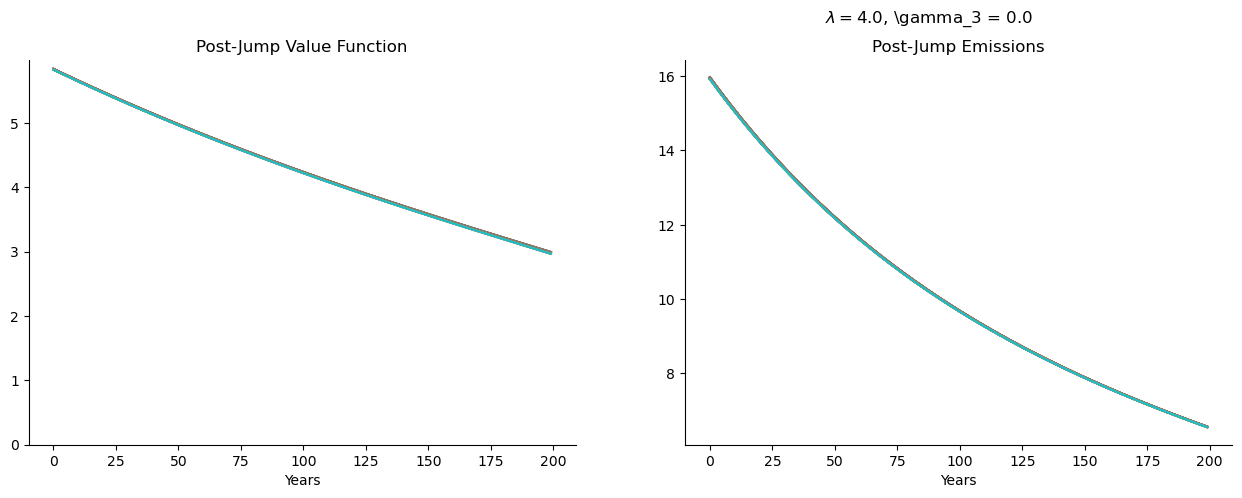

In [10]:
for k in range(len(λ_list)):
    for j in range(len(γ3_list)):
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ_list[k], γ3_list[j])
        os.chdir(newpath)
        ϕ_plot  = np.load('v_list_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ_list[k], γ3_list[j]))
        ems_plot= np.load("e_list_λ_{:.12f}_γ3_{:.12f}.npy".format(λ_list[k], γ3_list[j]))
        fig = plt.figure(figsize=(24, 5))
        fig.suptitle(f"$\lambda = {λ_list[k]}$, \gamma_3 = {γ3_list[j]}")
        plt.subplot(131)
        plt.title("Post-Jump Value Function")
        plt.plot(ϕ_plot)
        plt.ylim(0)
        plt.xlabel("Years")
        plt.subplot(132)
        plt.title("Post-Jump Emissions")
        plt.plot(ems_plot)
        plt.xlabel("Years")
        plt.savefig("EV_plot_λ_{:.12f}_γ3_{:.12f}.png".format(λ_list[k], γ3_list[j]))
        plt.show()

In [11]:
if np.isscalar == True:
    γ3_len = 1
else:
    γ3_len = len(γ3_list)
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
stateSpace2 = np.hstack([y1_mat_cap.reshape(-1,1, order='F'), y2_mat_cap.reshape(-1,1,order='F')])
loc_2 = np.abs(y1_grid - 2.).argmin()
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
dΛ1 = γ1 + γ2 * y1_mat_cap
dmg_weight = np.ones(γ3_len) / γ3_len

πd_o = np.ones((γ3_len, num_y1, num_y2)) / γ3_len
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
r1 = 1.5
r2 = -2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2 * (y1_mat_cap <= y_lower)))

In [12]:
@ray.remote
def solve_prep_pre(y1_mat_cap, y2_mat_cap, γ3_list, λ, ξp, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05, vfraction =0.05):
    ϕ_list = np.zeros((γ3_len, len(y1_grid), len(y2_grid)))
    for i in range(γ3_len):
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ, γ3_list[i])
        os.chdir(newpath)
        ϕ_list[i]  = np.load('v_list_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ, γ3_list[i]))
    ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)
    ϕ_equiv = -ξp * np.log(ϕ_weight)
    ems = η
    ems_old = ems
    lhs_error = 1
    episode = 0
    v0 = ϕ_equiv[:num_y1]
    v_m = np.zeros(πd_o.shape)
    for i in range(len(γ3_list)):
        v_m[i] = ϕ_list[i][loc_2]

    while lhs_error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
        v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
        # updating controls
        weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa < 1e-15] = 1e-15
        πa = πa / np.sum(πa, axis=0)
        ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new * fraction + ems_old * (1-fraction)
        ems[ems <= 1e-10] = 1e-10
        #     print(np.min(ems))
        g_m = np.exp(1 / ξp * (v0 - v_m))
        # HJB coefficient
        A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
        B_y1 = y2_mat_cap
        B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
        C_yy1 = np.zeros(y1_mat_cap.shape)
        C_yy2 = np.zeros(y1_mat_cap.shape)
        D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
            πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
                πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                    πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
        phi_mat = false_transient_one_iteration_cpp(
            stateSpace2,
            A,
            B_y1,
            B_y2,
            C_yy1,
            C_yy2,
            D,
            v0,
            ϵ)
        rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
        v0 = phi_mat
        ems_old = ems
        episode += 1
        result = dict(v0=v0, ems=ems, g_m=g_m,v0_dy1=v0_dy1, 
                  v0_dy2=v0_dy2, episode = episode, lhs_error = lhs_error, rhs_error= rhs_error )
        print(lhs_error)
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))
    return (result)



In [13]:
tol       = 1e-6
ϵ         = 0.1
max_iter  = 8000
fraction  = 0.4
vfraction = 1
ξp        = 1
γ3_len    = len(γ3_list)

In [14]:

rest_list = [solve_prep_pre.remote(y1_mat_cap, y2_mat_cap, 
                            γ3_list, λ, ξp, tol, ϵ, max_iter, fraction, vfraction) for λ in λ_list]
rest_list = ray.get(rest_list)

2021-08-10 08:56:23,052	WARNING worker.py:1189 -- Warning: The remote function __main__.solve_prep_pre has size 12431227 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=17216) 1.012183163499225
(pid=17216) 0.8530152833038507
(pid=17216) 0.7340710302464881
(pid=17216) 0.6418337619757963
(pid=17216) 0.5687481089782231
(pid=17216) 0.510053120964491
(pid=17216) 0.4620167320367674
(pid=17216) 0.4222008736121996
(pid=17216) 0.3887958877101294
(pid=17216) 0.3604303580424162
(pid=17216) 0.3360482183359448
(pid=17216) 0.31482523567425424
(pid=17216) 0.2963298752548571
(pid=17216) 0.27995407857337007
(pid=17216) 0.2653774768622874
(pid=17216) 0.25238636239485857
(pid=17216) 0.24068707181234217
(pid=17216) 0.23009706512413075
(pid=17216) 0.2204656616196221
(pid=17216) 0.21166515476608083
(pid=17216) 0.2036073521779791
(pid=17216) 0.19621777453393996
(pid=17216) 0.18938691566947163
(pid=17216) 0.18304391133286302
(pid=17216) 0.1771343487952226
(pid=17216) 0.17168763947240429
(pid=17216) 0.16657210331298522
(pid=17216) 0.1617644604299695
(pid=17216) 0.157305050652905
(pid=17216) 0.153068923561559
(pid=17216) 0.1491141930840989
(pid=17216) 0.14536525164854375


(pid=17216) 0.00023512199133435274
(pid=17216) 0.00021465811391507827
(pid=17216) 0.00019594471606154684
(pid=17216) 0.00017883663309348208
(pid=17216) 0.00016319803036957126
(pid=17216) 0.00014889197350598238
(pid=17216) 0.0001358202401480213
(pid=17216) 0.00012387383780065875
(pid=17216) 0.00011295345304418447
(pid=17216) 0.00010297783457957621
(pid=17216) 9.386784745046839e-05
(pid=17216) 8.553920126885828e-05
(pid=17216) 7.793223097962709e-05
(pid=17216) 7.09859847258798e-05
(pid=17216) 6.464619511703518e-05
(pid=17216) 5.885697700769299e-05
(pid=17216) 5.357744425893429e-05
(pid=17216) 4.876120045516075e-05
(pid=17216) 4.4367513476473164e-05
(pid=17216) 4.036003236507213e-05
(pid=17216) 3.670343136086274e-05
(pid=17216) 3.336807005815956e-05
(pid=17216) 3.0320258836979974e-05
(pid=17216) 2.753164716651213e-05
(pid=17216) 2.4983234672149024e-05
(pid=17216) 2.2641023678104943e-05
(pid=17216) 2.0496390487068084e-05
(pid=17216) 1.85363731031174e-05
(pid=17216) 1.6748580575765004e-05
(

In [15]:
i=0

for k in range(len(λ_list)):
    v0_pre_list      = rest_list[i]['v0']
    ems_pre_list     = rest_list[i]['ems']
    gm_pre_list      = rest_list[i]['g_m']
    v0_dy1_list      = rest_list[i]['v0_dy1']
    v0_dy2_list      = rest_list[i]['v0_dy2']
    episode_pre_list = rest_list[i]['episode']
    rhs_pre_list     = rest_list[i]['rhs_error']
    lhs_pre_list     = rest_list[i]['lhs_error']
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ_list[k],γ3_len)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    os.chdir(newpath)
    np.save("v0_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ_list[k], γ3_len), v0_pre_list)
    np.save("ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ_list[k], γ3_len), ems_pre_list)
    np.save("gm_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ_list[k], γ3_len), gm_pre_list)
    np.save("v0_dy1_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ_list[k], γ3_len), v0_dy1_list)
    np.save("v0_dy2_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ_list[k], γ3_len), v0_dy2_list)
    np.save('Parameter specifications_λ_{:.12f}_γ3_len_{:.12f}'.format(λ_list[k], γ3_len), (λ_list[k], γ3_list, ξp,
                                                 tol, ϵ, max_iter, fraction, 
                                                 y1_step, y2_step))
    np.save('Count Timer and Episode Length_λ_{:.12f}_γ3_len_{:.12f}'.format(λ_list[k], γ3_len), [episode_pre_list, rhs_pre_list, lhs_pre_list])
    i = i+1

/Users/samuelzhao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


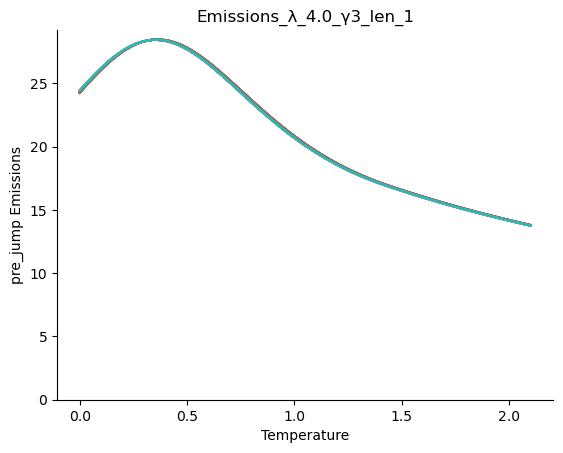

In [16]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    ems_pre_list_plot=np.load('ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy'.format(λ, γ3_len))
    fig = plt.figure()
    plt.title(f"Emissions_λ_{λ}_γ3_len_{γ3_len}")
    plt.plot(y1_grid_cap, ems_pre_list_plot)
    plt.ylim(0)
    plt.ylabel("pre_jump Emissions")
    plt.xlabel("Temperature")
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("E_pre_plot_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()


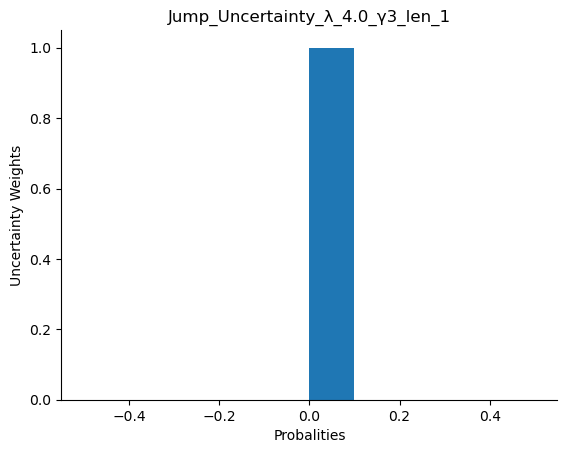

In [17]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    g_m_plot=np.load("gm_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    g_i = g_m_plot[:, -1, 2]
    fig = plt.figure()
    plt.title(f"Jump_Uncertainty_λ_{λ}_γ3_len_{γ3_len}")
    plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
    plt.ylabel("Uncertainty Weights")
    plt.xlabel("Probalities")
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("g_m_pre_plot_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()


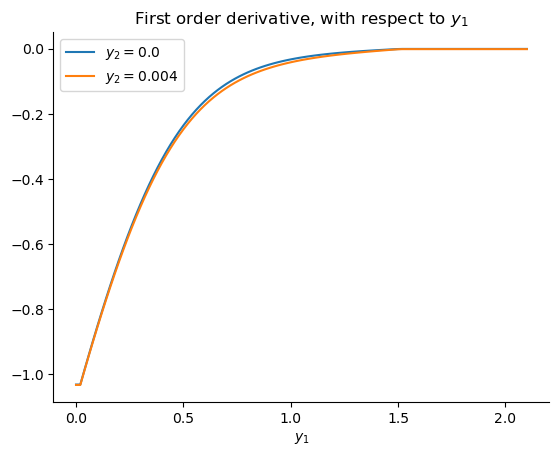

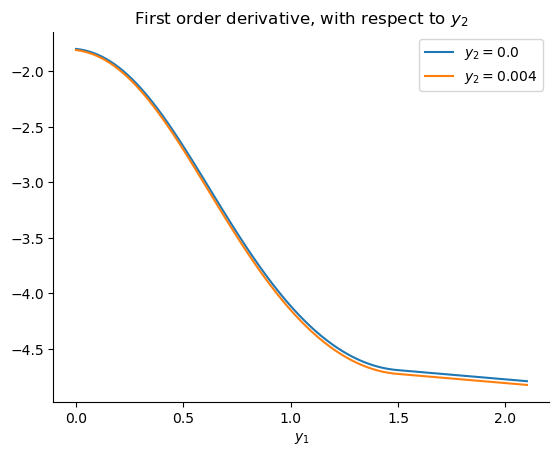

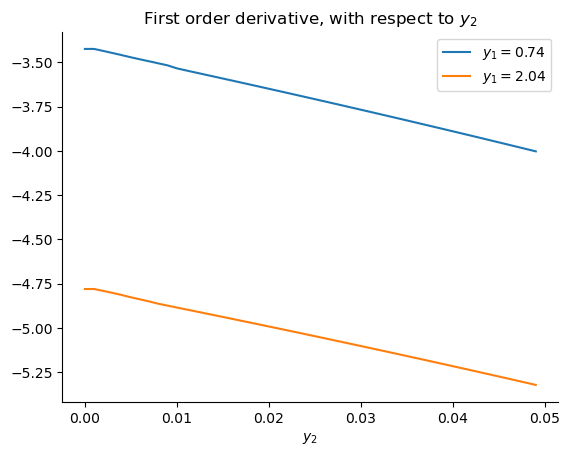

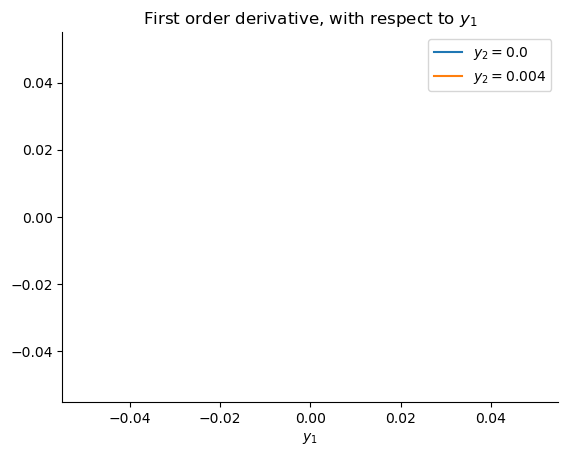

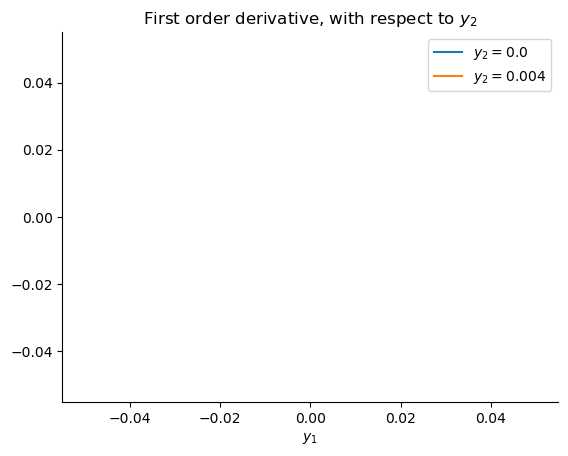

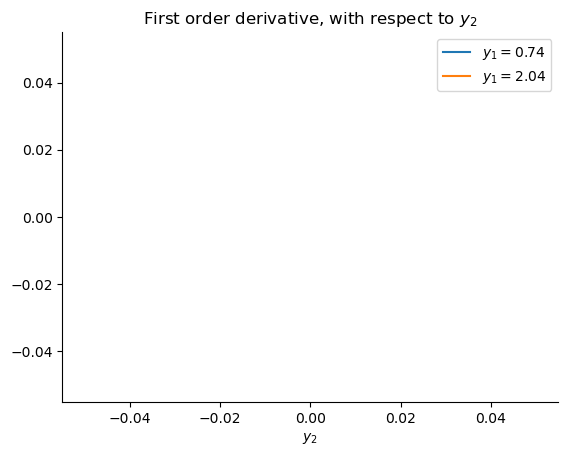

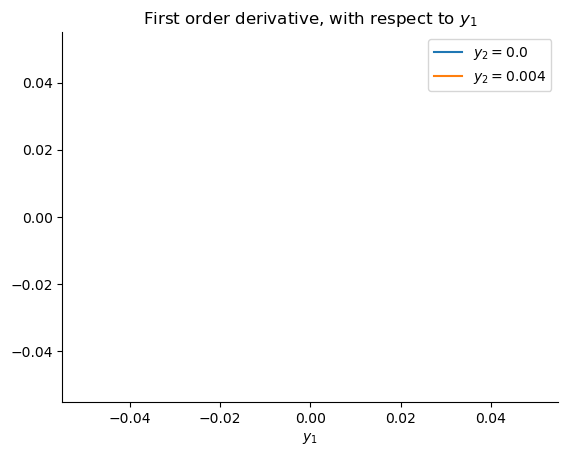

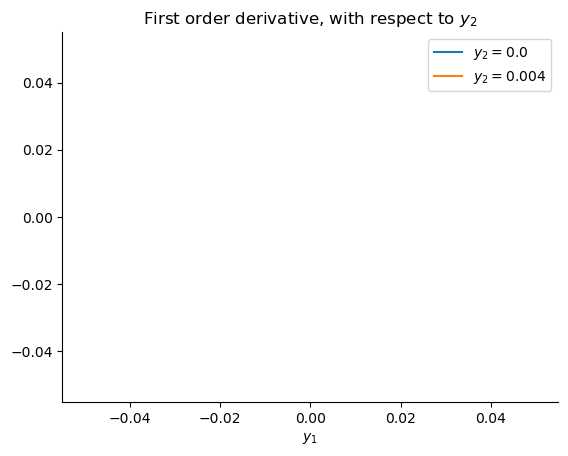

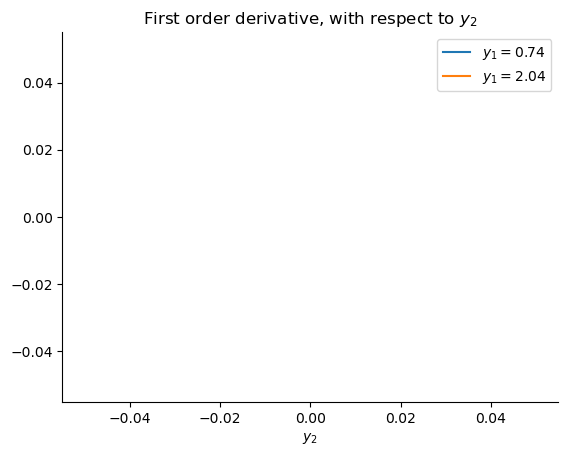

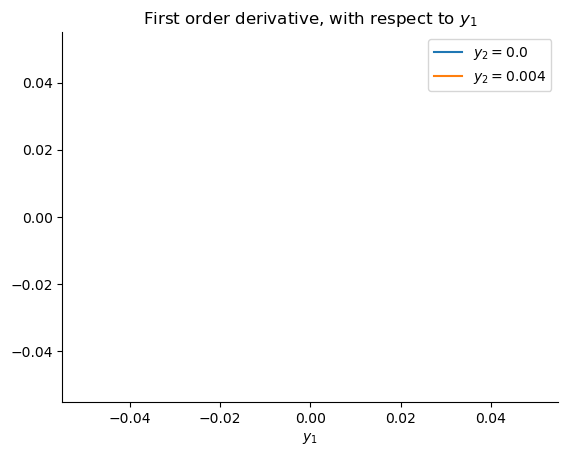

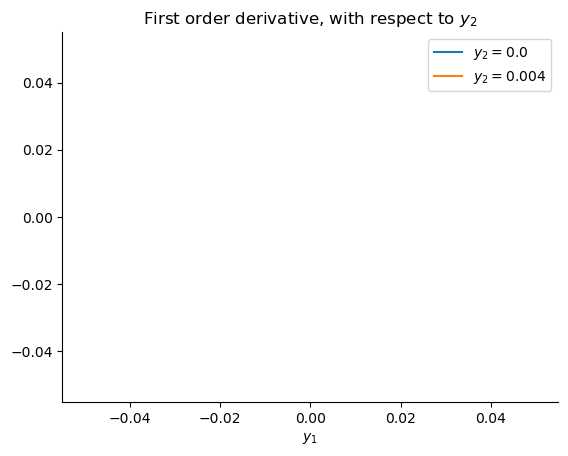

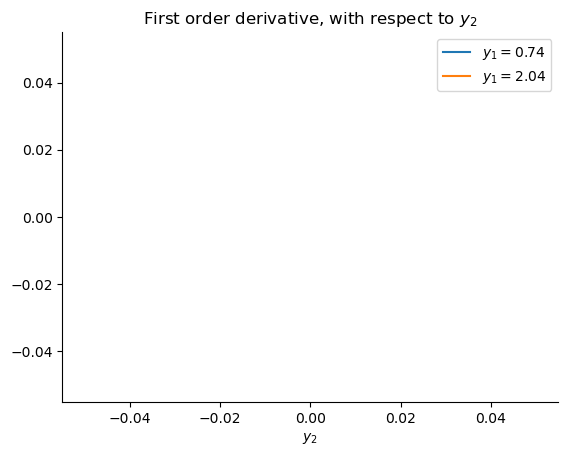

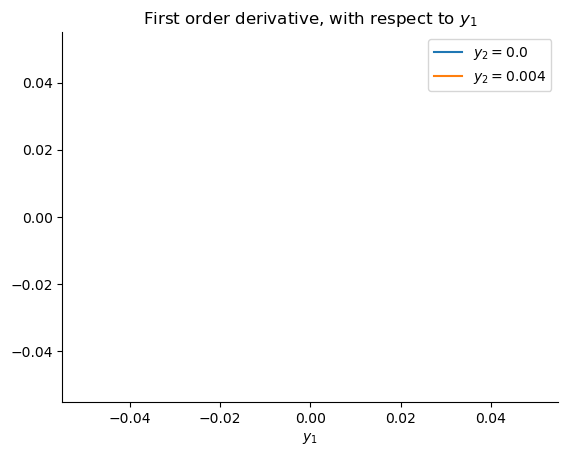

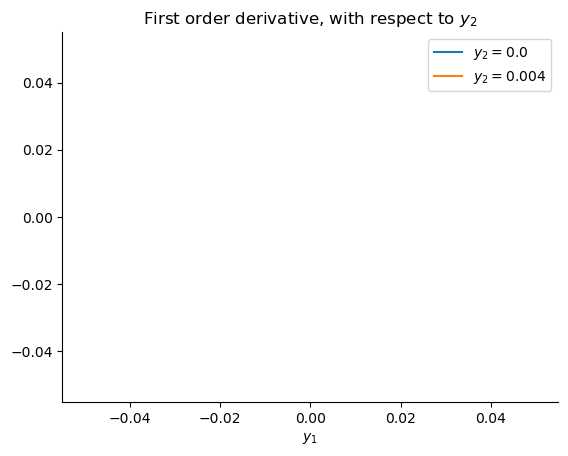

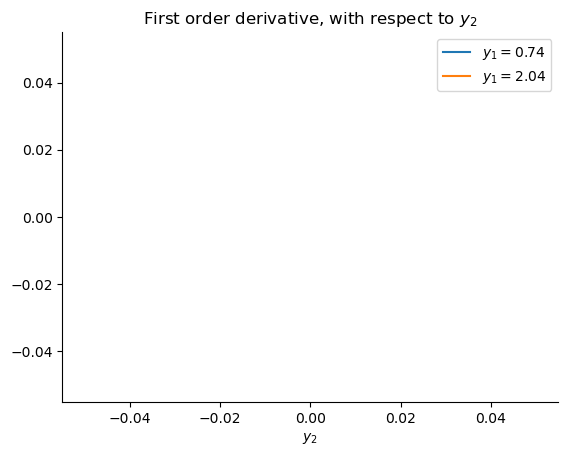

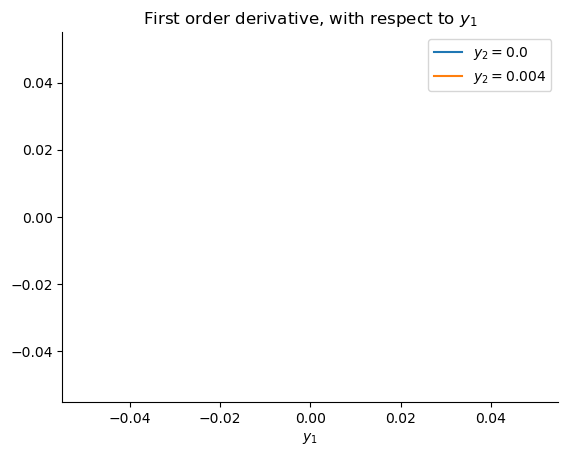

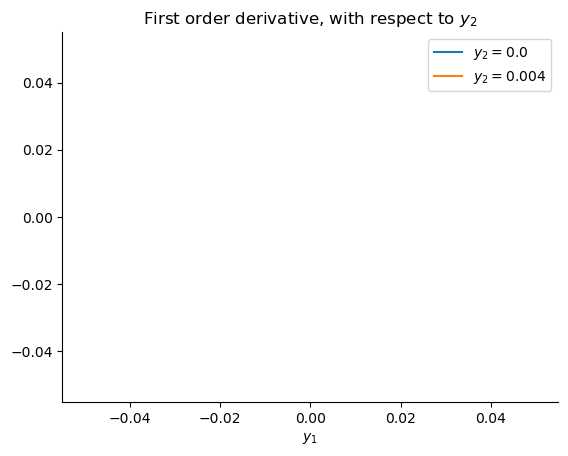

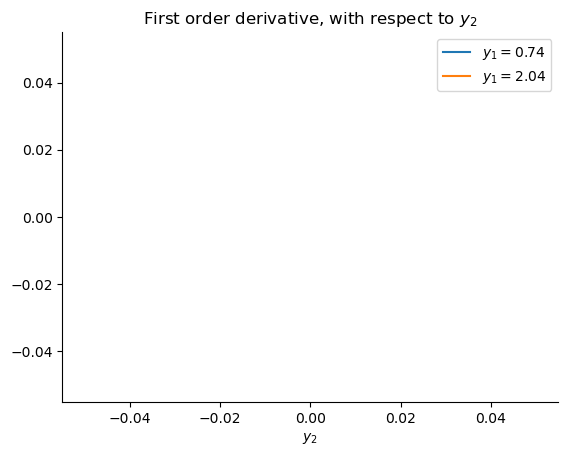

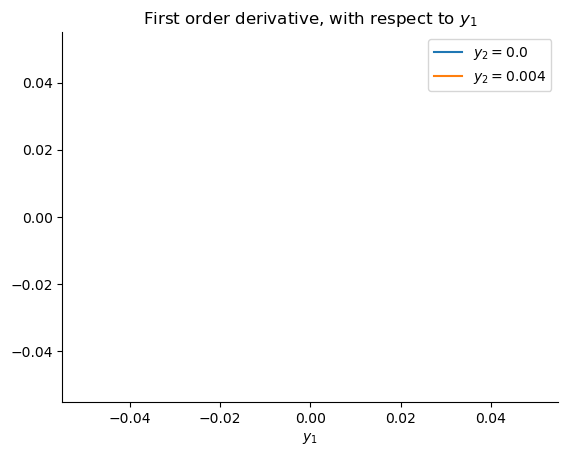

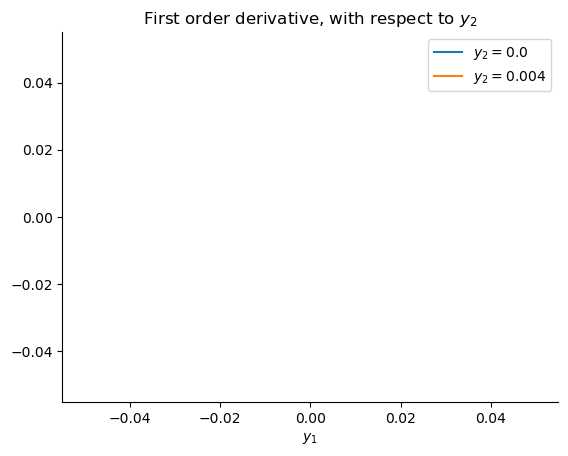

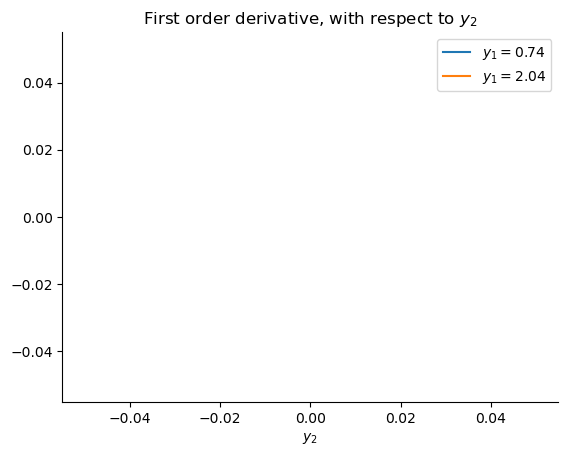

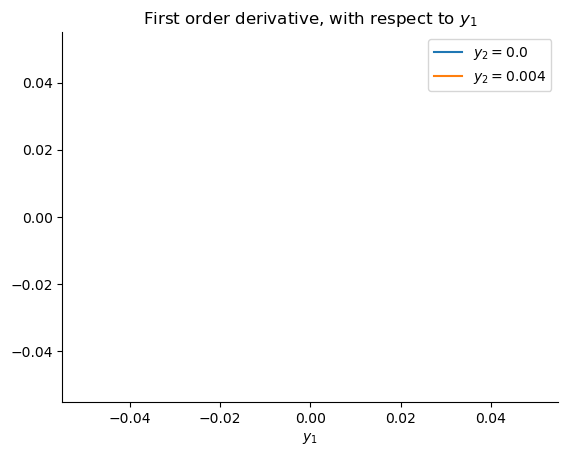

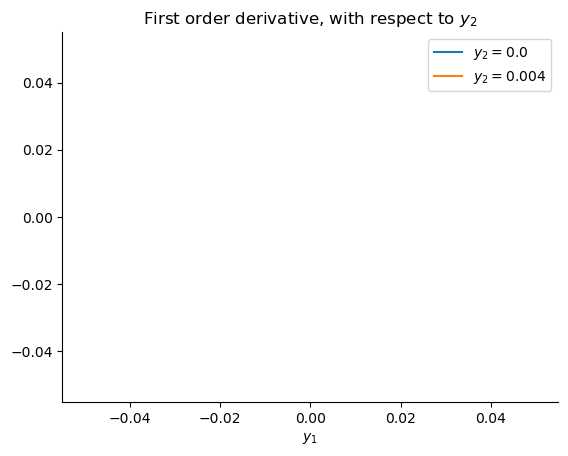

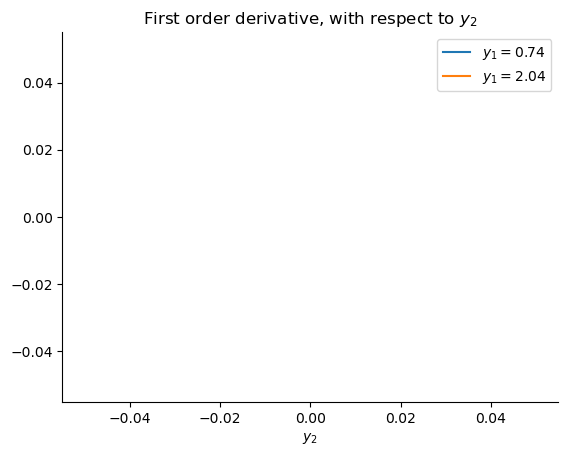

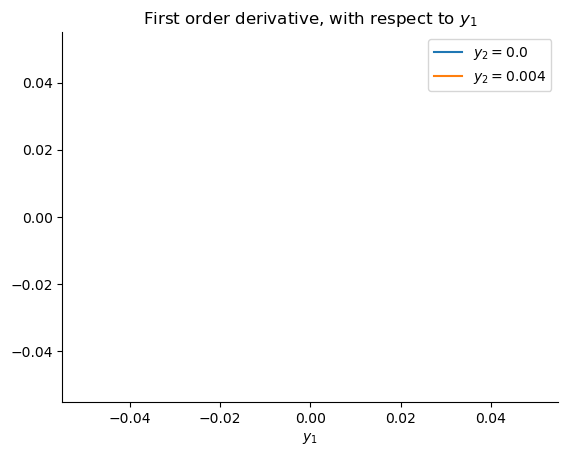

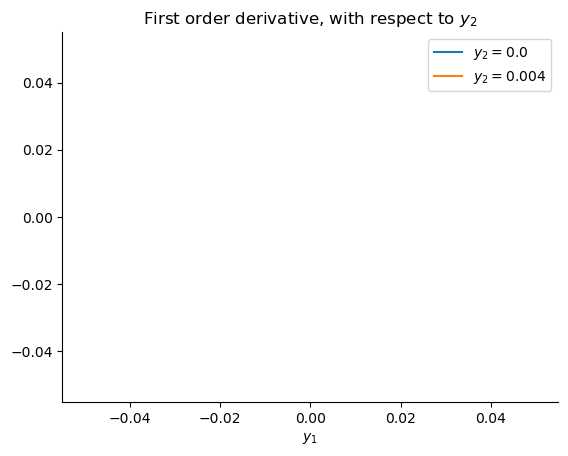

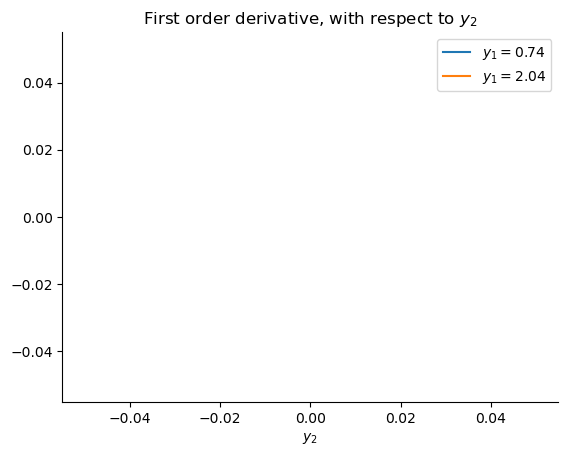

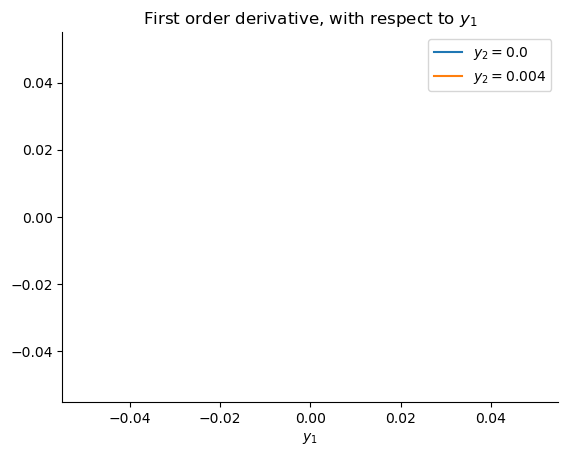

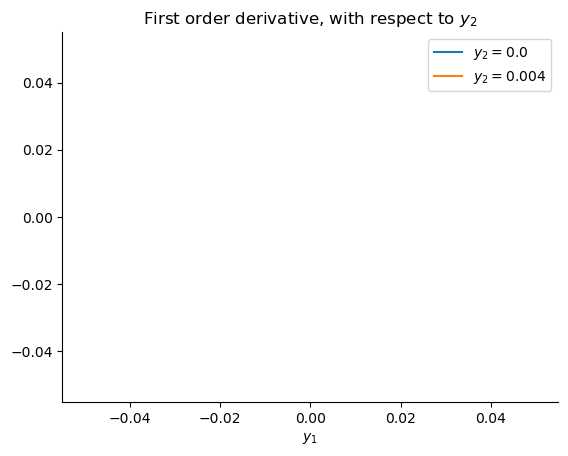

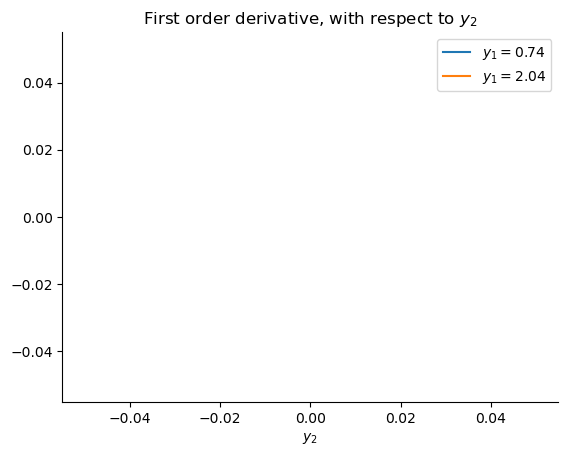

In [16]:
#computation of derivatives
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    v0_dy1=np.load("v0_dy1_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    v0_dy2=np.load("v0_dy2_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    
    
    plt.title("First order derivative, with respect to $y_1$")
    plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
    plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
    plt.xlabel(r"$y_1$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y1_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    
    plt.title("First order derivative, with respect to $y_2$")
    plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
    plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
    plt.xlabel(r"$y_1$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    
    plt.title("First order derivative, with respect to $y_2$")
    plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
    plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
    plt.xlabel(r"$y_2$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y2_under_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    

In [17]:
from scipy import interpolate
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [18]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

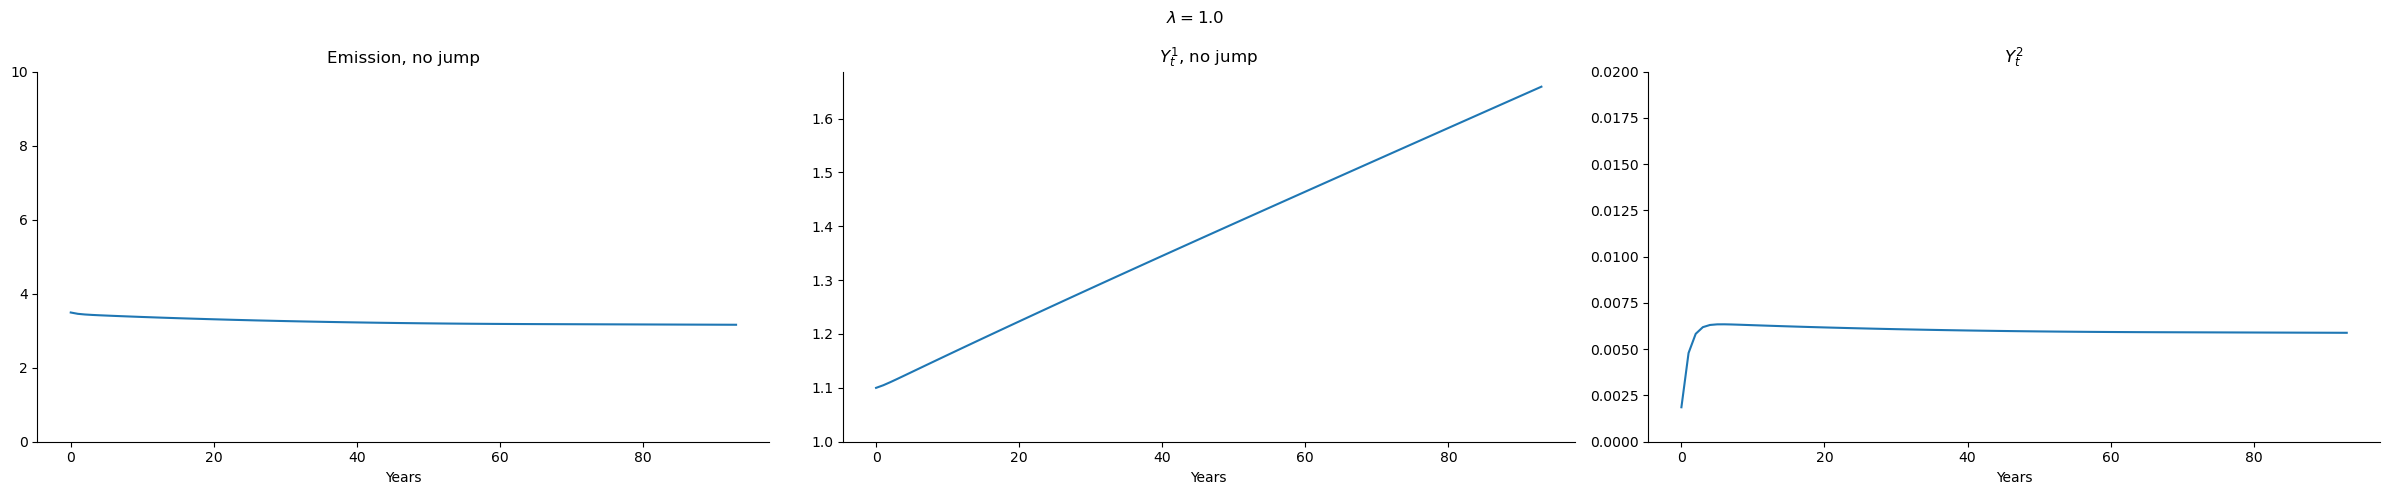

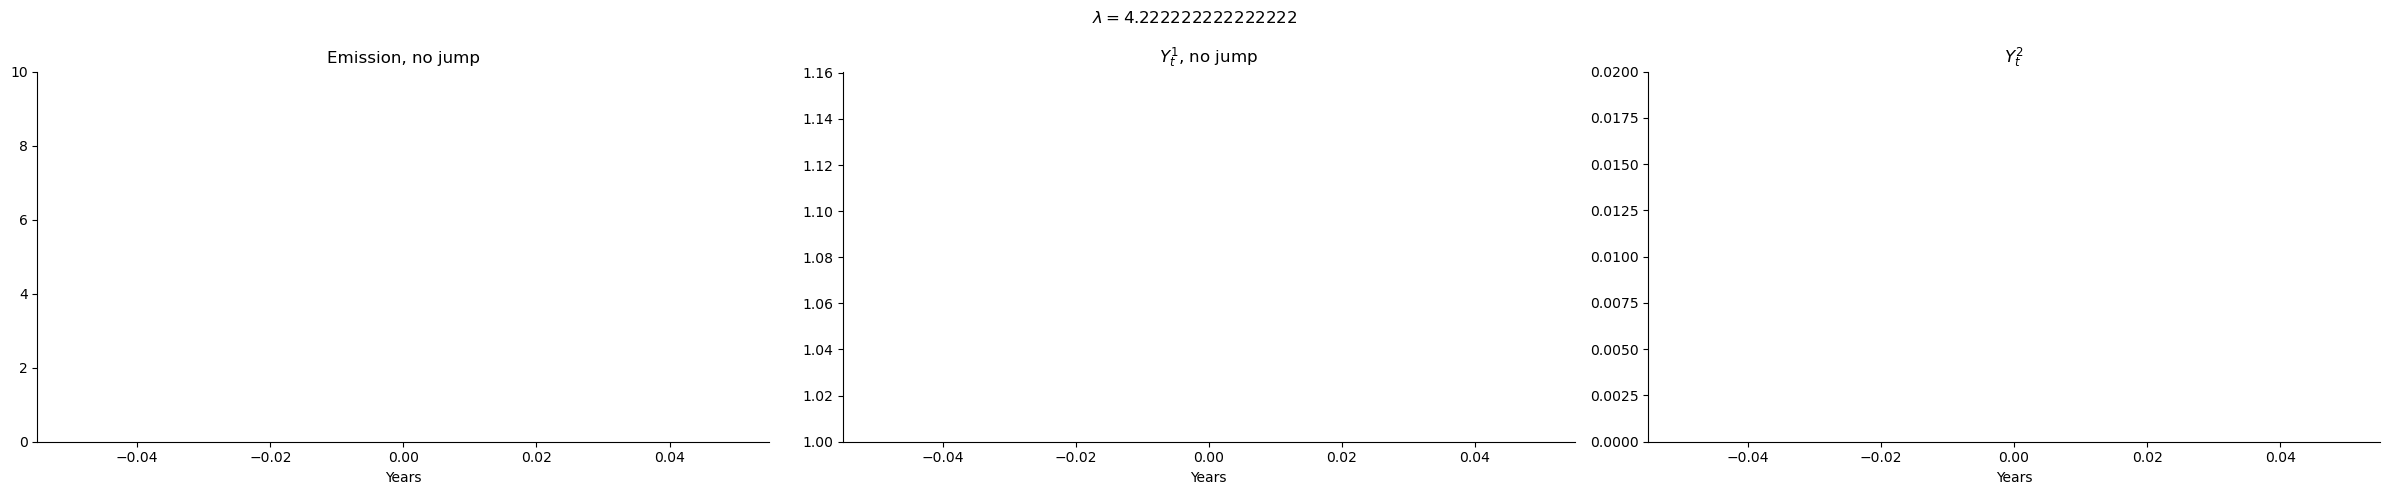

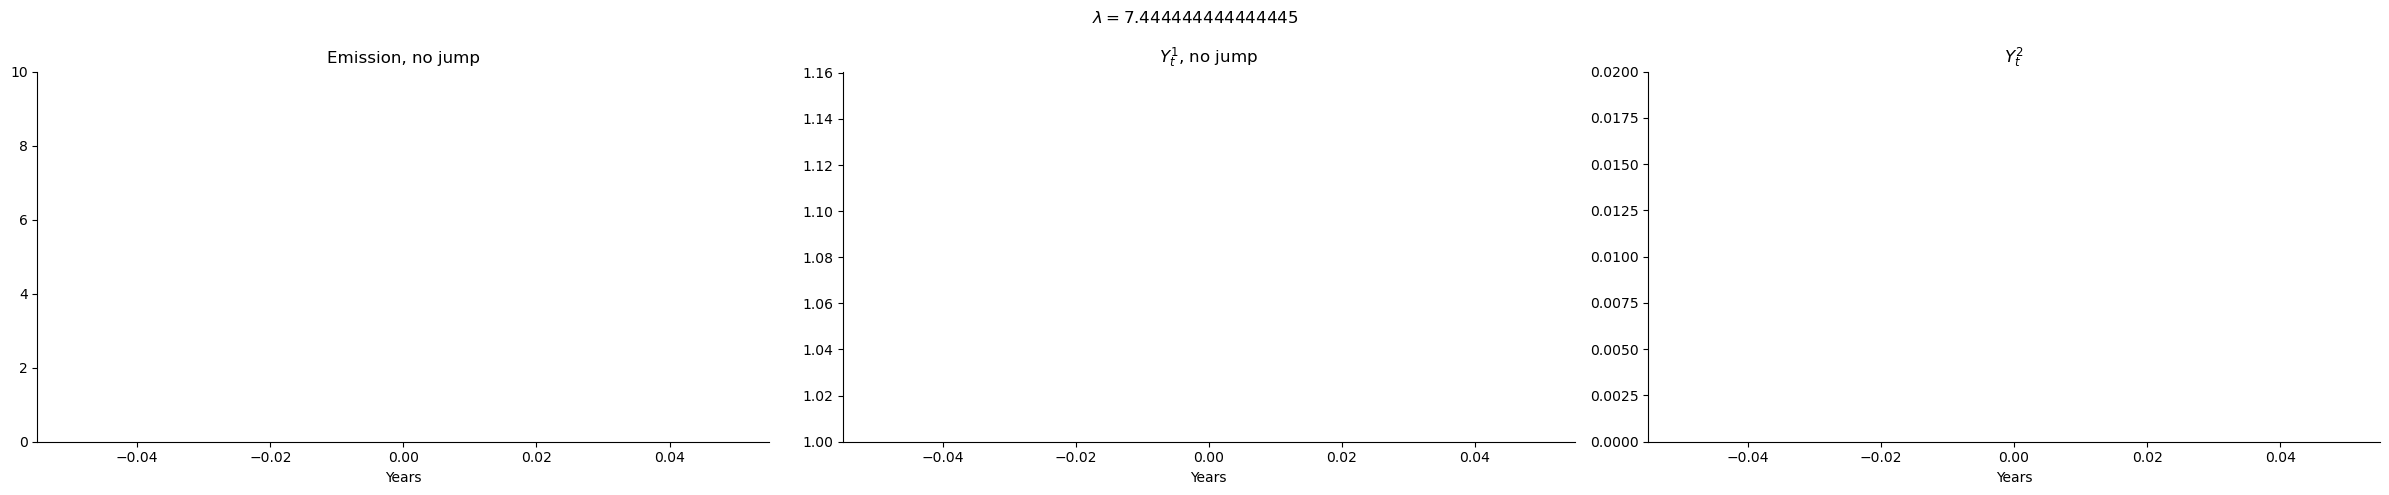

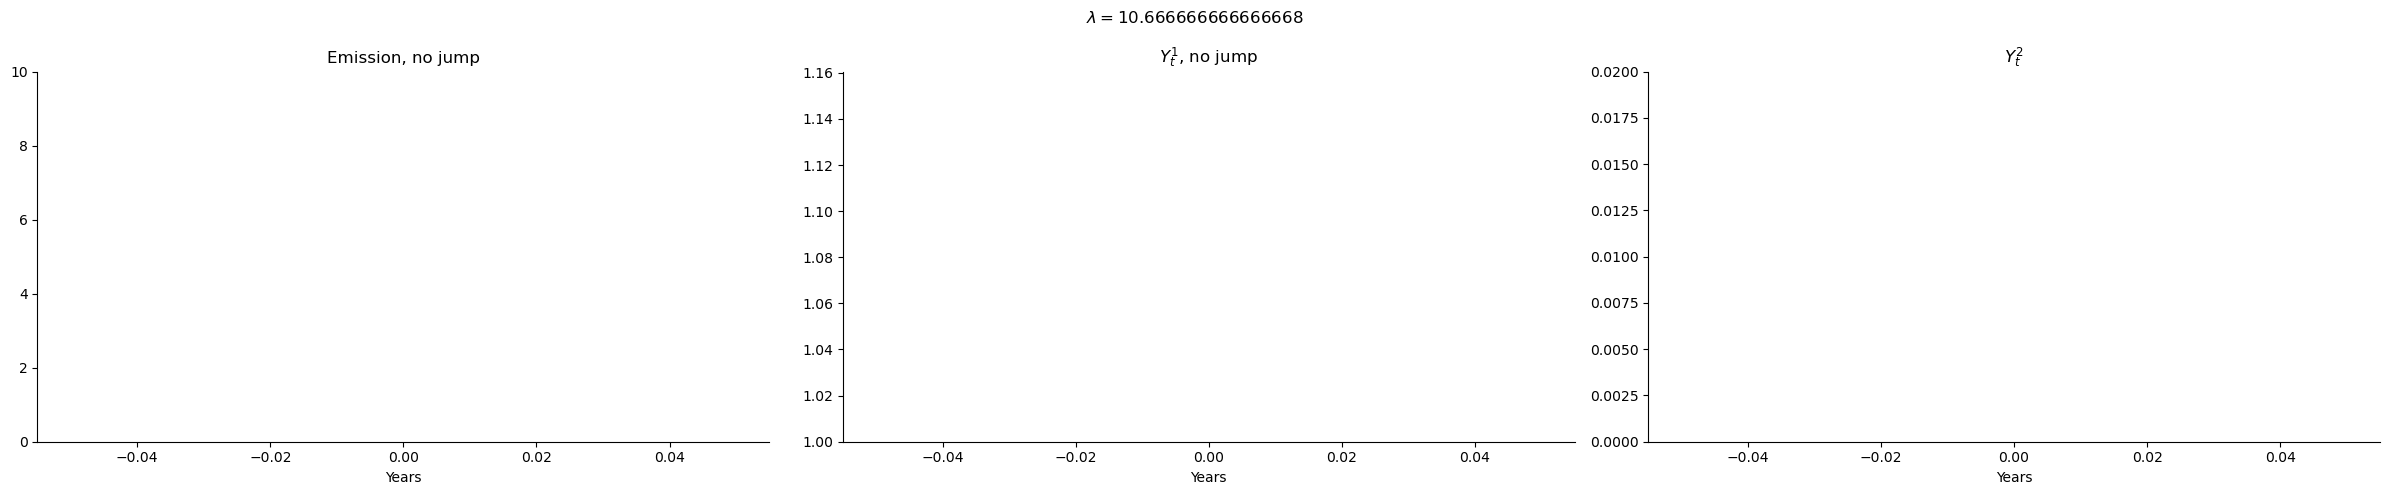

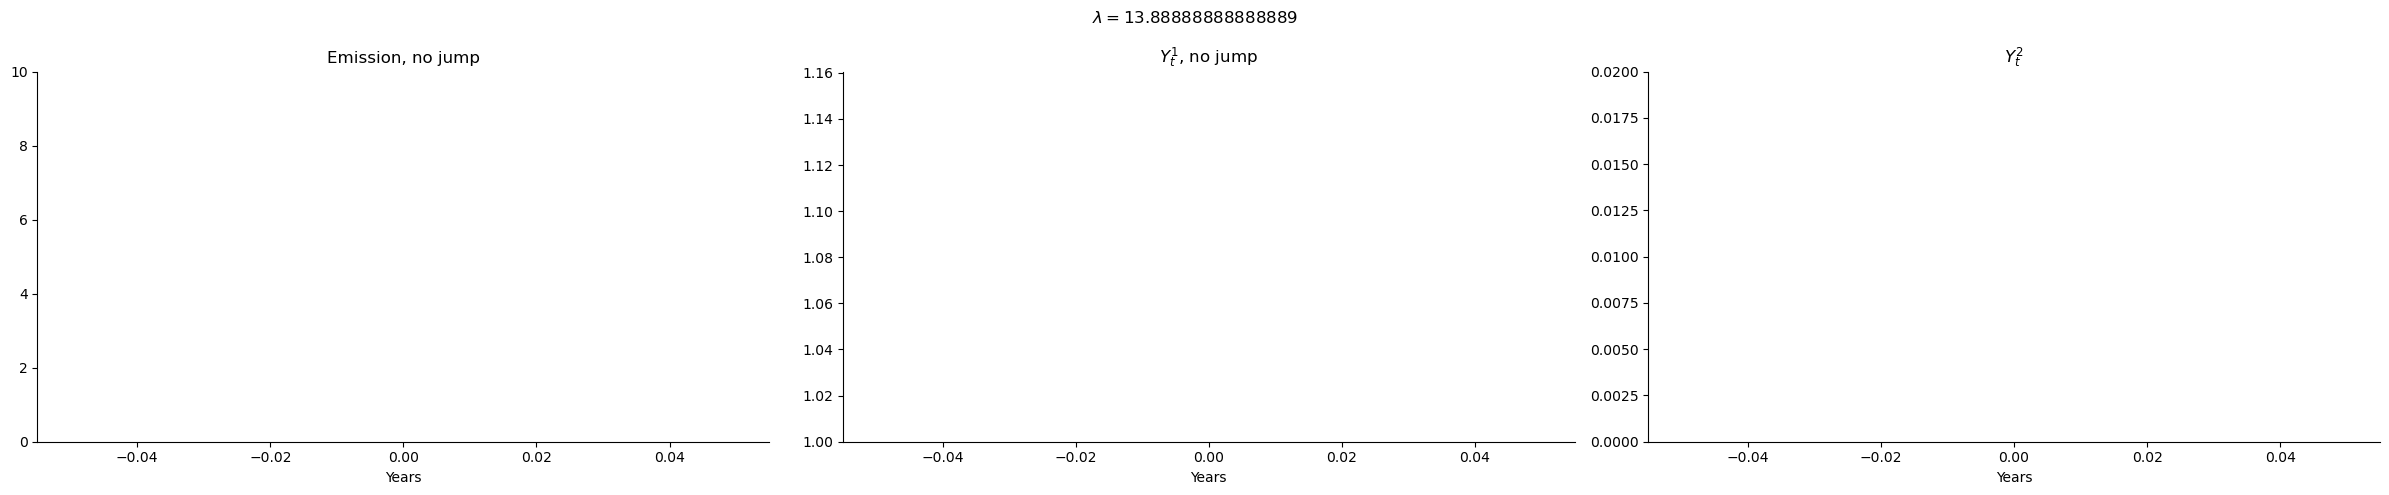

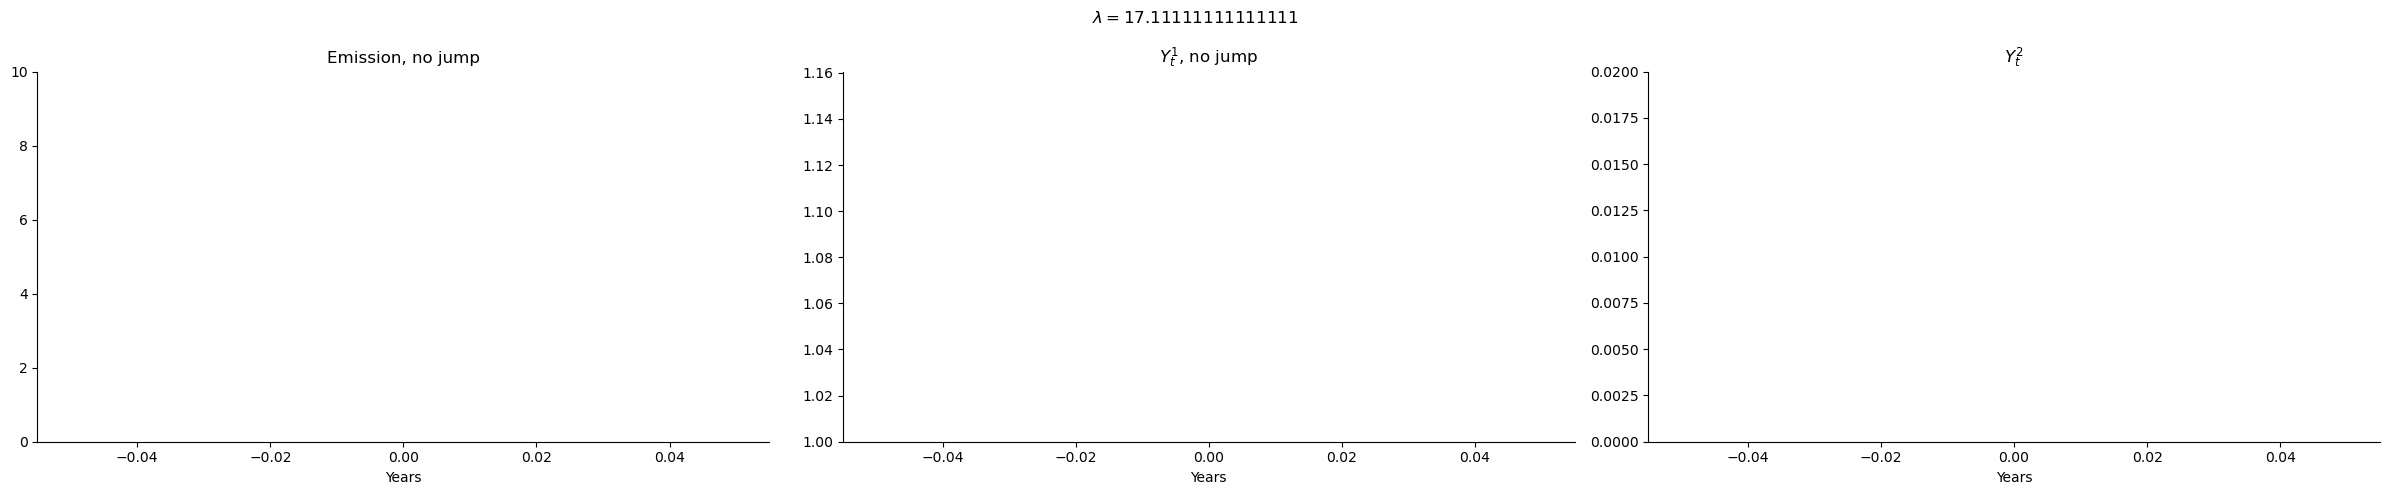

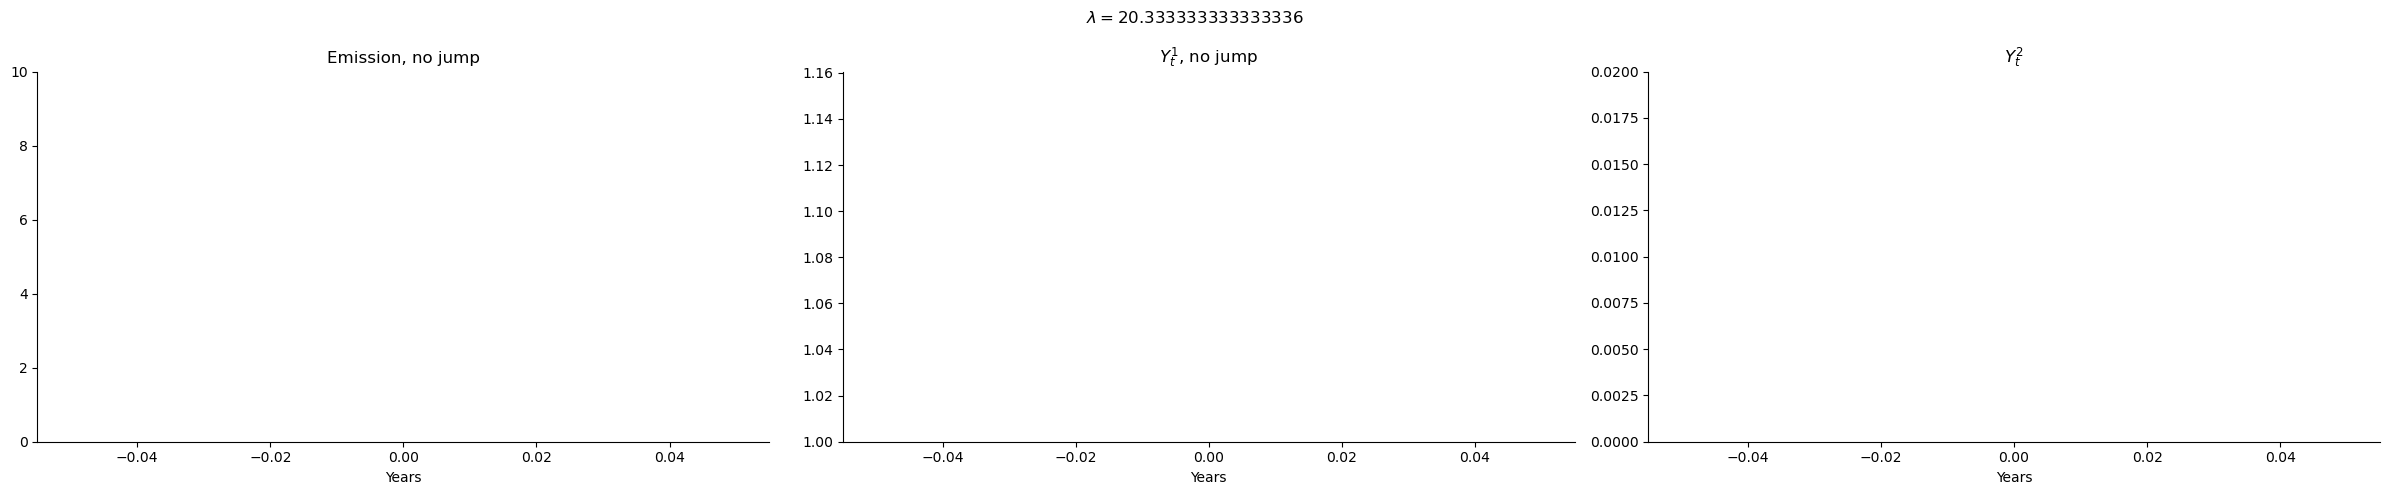

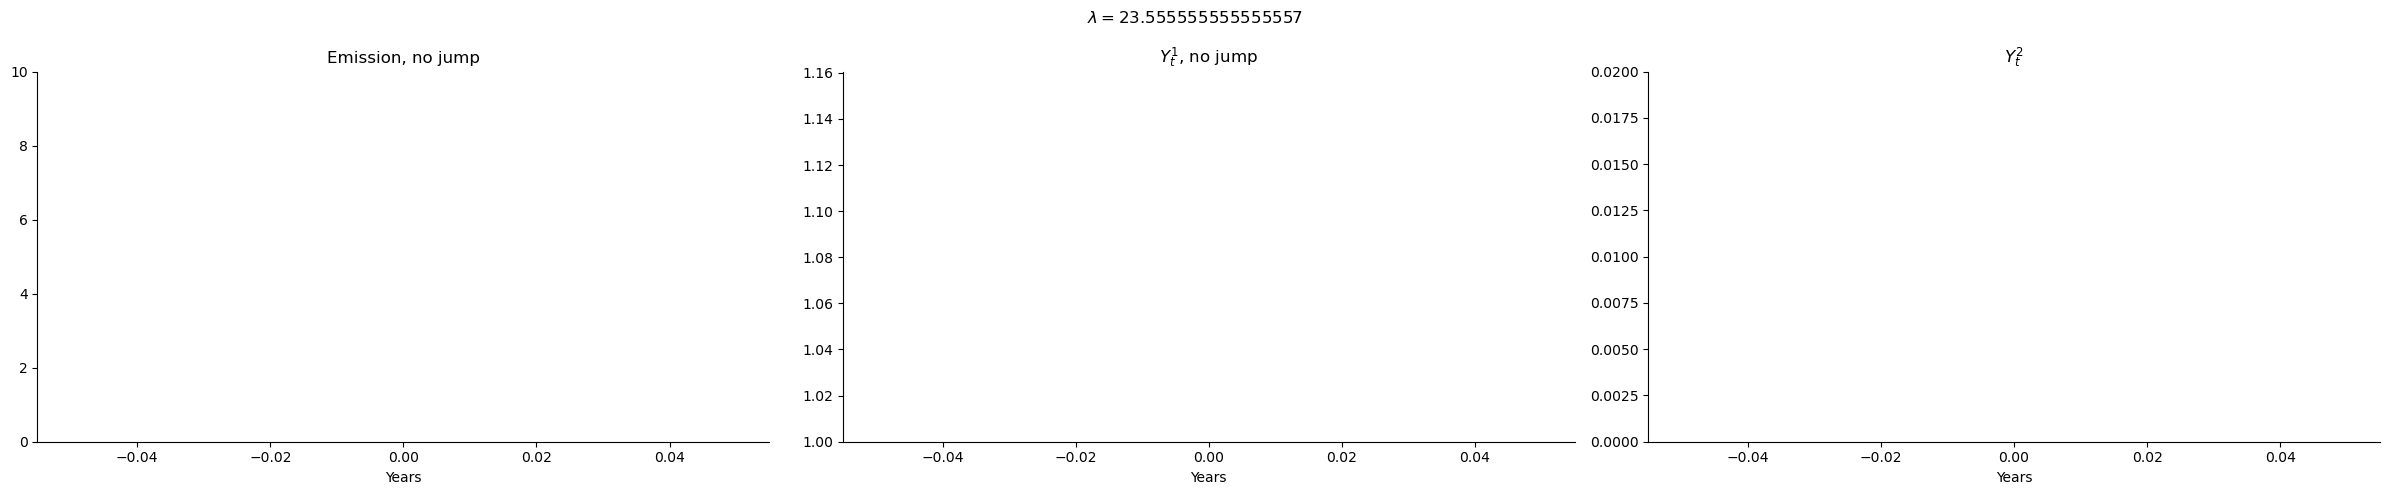

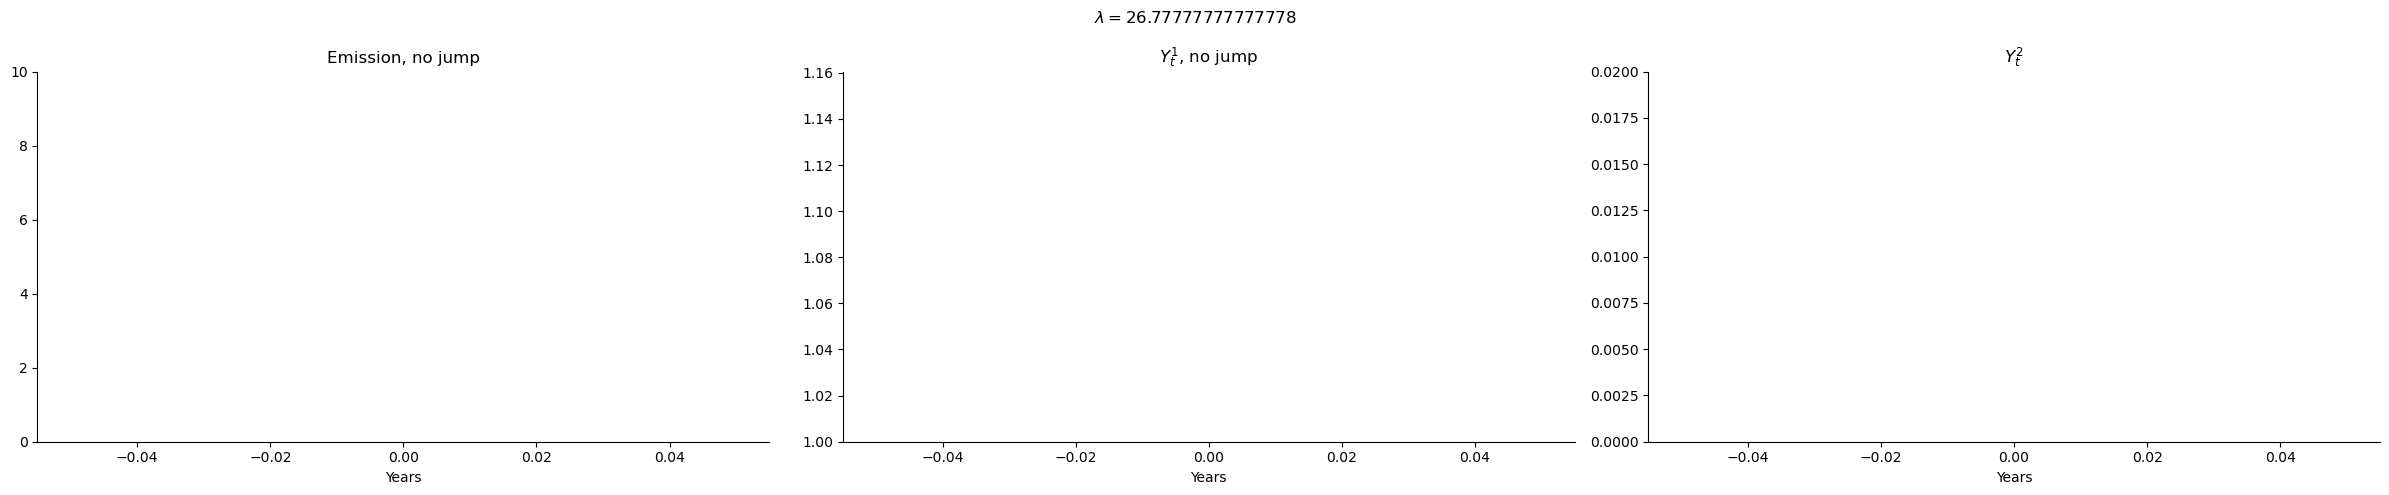

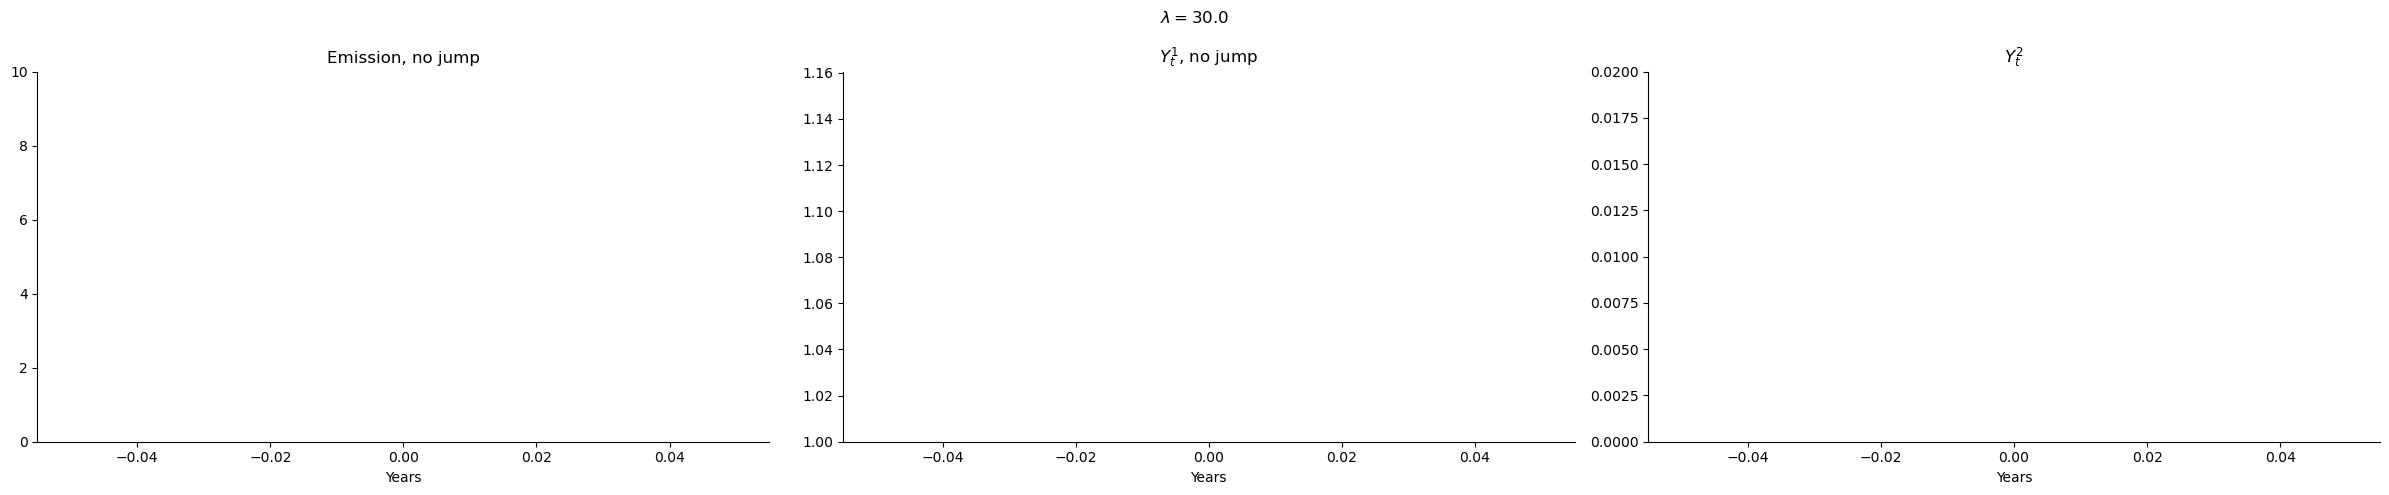

In [19]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    ems=np.load('ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy'.format(λ, γ3_len))
    et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                      y2_grid,
                                                      ems,
                                                      λ,
                                                      θ=np.mean(θ_list),
                                                      y1_0 = 1.1,
                                                      y2_0=np.mean(θ_list),
                                                      T=93
                                                     )
    simul = {
        "et": et_prejump,
        "y1t": y1t_prejump,
        "y2t": y2t_prejump,
    }

    pickle.dump(simul, open("simul_2", "wb"))
    fig = plt.figure(figsize=(24, 5))
    fig.suptitle(f"$\lambda = {λ}$")
    plt.subplot(131)
    plt.title("Emission, no jump")
    plt.plot(et_prejump)
    plt.ylim(0,10)
    plt.xlabel("Years")
    plt.subplot(132)
    plt.xlabel("Years")
    plt.title(r"$Y_t^1$, no jump")
    plt.plot(y1t_prejump)
    plt.ylim(1)
    plt.subplot(133)
    plt.title(r"$Y_t^2$")
    plt.plot(y2t_prejump)
    plt.ylim(0, 0.02)
    plt.xlabel("Years")
    plt.tight_layout()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_cpp{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("e_y1_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()